# Setup

## Packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams, cycler
import matplotlib
from matplotlib.lines import Line2D
from trendmaster import trend
import itertools
from scipy import stats
import datetime
import pickle
from pathlib import Path
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.ticker import FormatStrFormatter

## Loading data

In [2]:
def saveDict(dictionary,filename):
    """
    Saves dictionary to pickle file in working directory.
    
    Parameters
    ----------
    dictionary: dict
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    Nothing
    """
    f = open(f"{filename}.pkl","wb")
    pickle.dump(dictionary,f)
    f.close()

def openDict(filename):
    """
    Opens dictionary from pickle file in working directory.
    
    Parameters
    ----------
    filename: str
        filename without .pkl ending
    
    Returns
    -------
    dictionary
    """
    pickle_in = open(f"{filename}.pkl","rb")
    loadedDict = pickle.load(pickle_in)
    return loadedDict

def findFS(variable="_",region="_",MA="day",years="year",resultDir="Reshaped"):
    """
    Finds .npy-files for a specific variable and moving average smoothing (MA) in a directory.
    
    Parameters
    ----------
    variable: str
    MA: str
    
    Returns
    -------
    list of files
    """
    # set folder
    folder = Path(resultDir)
    
    # make list of strings
    files = []
    for item in sorted(folder.glob(f"*{variable}*{region}*{MA}*{years}*")):
        files.append(str(item))
    
    return files

In [3]:
ost = openDict("ostlandet_final")
vest = openDict("vestlandet_final")
sor = openDict("sorlandet_final")
trond = openDict("trondelag_final")
nord = openDict("nordland_final")
finn = openDict("finnmark_final")

altitudes = {}
altitudes["ost"] = np.array(ost["metadata"][ost["metadata"].snumber.isin(ost["final30"])].altitude)
altitudes["vest"] = np.array(vest["metadata"][vest["metadata"].snumber.isin(vest["final30"])].altitude)
altitudes["sor"] = np.array(sor["metadata"][sor["metadata"].snumber.isin(sor["final30"])].altitude)
altitudes["trond"] = np.array(trond["metadata"][trond["metadata"].snumber.isin(trond["final30"])].altitude)
altitudes["nord"] = np.array(nord["metadata"][nord["metadata"].snumber.isin(nord["final30"])].altitude)
altitudes["finn"] = np.array(finn["metadata"][finn["metadata"].snumber.isin(finn["final30"])].altitude)

# so far only for 10dMA
variables = ["rainfall","snowmelt","streamflow","temperature"]
years = [30,50]
averages = ["5day","10day","30day"]
FS = {}
for MA in averages:
    FS[MA] = {}
    for year in years:
        FS[MA][year] = {}
        for var in variables:
            FS[MA][year][var] = {}
            files = findFS(variable=var,MA=MA,years=str(year),resultDir="Results/FS")
            for file in files:
                region = file.split("_")[2]
                FS[MA][year][var][region] = pd.read_csv(file)

annTrends30yr5a = pd.read_csv("annualTrends_30years_a5.csv")
annTrends50yr5a = pd.read_csv("annualTrends_50years_a5.csv")
annTempTrends30yr5a = pd.read_csv("annualTempTrends_30years_a5.csv")
annTempTrends50yr5a = pd.read_csv("annualTempTrends_50years_a5.csv")

# Plotting daily trends

## Functions

In [4]:
regionLabels = {"ost":"Østlandet",
                "vest":"Vestlandet",
                "nord":"Nordland",
                "finn":"Finnmark",
                "trond":"Trøndelag",
                "sor":"Sørlandet"}
units = {"runoff":"$m^3\ s^{-1}\ yr^{-1}$",
         "spesrunoff":"$m^3\ s^{-1}km^{-2}\ yr^{-1}$",
         "temperature":"$^{\circ}C\ yr^{-1}$",
         "temp":"$^{\circ}C\ yr^{-1}$",
         "rainfall":"$mm\ yr^{-1}$",
         "snowmelt":"$mm\ yr^{-1}$",
         "streamflow":"$m^3\ s^{-1}km^{-2}\ yr^{-1}$"}
v = {"runoff":"streamflow",
       "spesrunoff":"specific streamflow",
       "temperature":"temperature",
       "rainfall":"rainfall",
       "snowmelt":"snowmelt",
       "streamflow":"streamflow"}

def findFiles(variable,MA,years,head="trend",resultDir="Results"):
    """
    Finds .npy-files for a specific variable and moving average smoothing (MA) in a directory.
    
    Parameters
    ----------
    variable: str
    MA: str
    
    Returns
    -------
    list of files
    """
    # set folder
    folder = Path(resultDir)
    
    # make list of strings
    files = []
    for item in sorted(folder.glob(f"*{head}*_{variable}*{MA}*{years}*.npy")):
        files.append(str(item))
    
    return files

def plotTrendMag(array,variable,region,MA,years,filename,
                 display=False,subplotting=False,ax=None,overrideColormap=None,titleOverride=None,overrideAspect=None):
    """
    Plots a trend magnitudes arrays.
    """
    
    masked_array = np.ma.masked_where(array == -99, array)
    extent = np.array([np.mean(np.nanmax(masked_array,axis=1)),np.mean(np.nanmin(masked_array,axis=1))]).max()
    
    if variable=="temp" or variable=="temperature":
        cmap=plt.cm.get_cmap("coolwarm")
    else:
        cmap=plt.cm.get_cmap("coolwarm_r")
    
    if overrideColormap:
        cmap=plt.cm.get_cmap(overrideColormap)
    
    if years==30:
        df = annTrends30yr5a
        if variable == "temperature":
            df = annTempTrends30yr5a
    elif years==50:
        df = annTrends50yr5a
        if variable == "temperature":
            df = annTempTrends50yr5a
    
    if subplotting:
        if overrideAspect:
            aspect = overrideAspect
        else:
            aspect = 5
        im = ax.imshow(array,cmap,vmin=-extent,vmax=extent,aspect=aspect)
        if extent < 0.001:
            cbar = fig.colorbar(im,ax=ax,extend="both",format='%.1e',shrink=0.8,label=units[variable])
        else:
            cbar = fig.colorbar(im,ax=ax,extend="both",shrink=0.8,label=units[variable])
        ticklabs = cbar.ax.get_yticklabels()
        cbar.ax.set_yticklabels(ticklabs, fontsize=8)
        yloc = np.arange(0,array.shape[0],5)
        ax.set_yticks(yloc)
        ax.set_yticklabels(altitudes[region].astype(int)[yloc])

        monthLoc = [0,31,59,90,120,151,181,212,243,274,304,335]
        months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
        ax.set_xticks(monthLoc) 
        ax.set_xticklabels(months, fontsize=10,ha="left")
        
        if titleOverride:
            ax.set_title(titleOverride)
        else:
            ax.set_title(f"{regionLabels[region]}")

        # finding excluded catchments
        grey = []
        notgrey = []
        for i in range(array.shape[0]):
            if (array[i,:]==-99).all():
                grey.append(i)
            else:
                notgrey.append(i)
        # plotting excluded catchments in grey
        for i in grey:
            ax.axhline(i,color="whitesmoke",linewidth=4.7)
        
        #if variable != "temperature":
        try:
            field = np.array(FS[MA][years][var][region].fieldSignificant)
            x = np.arange(365).astype(float)
            y = np.full_like(x,-1.5)
            np.place(x,field==False,np.nan)
            np.place(y,field==False,np.nan)
            ax.plot(x,y,"-",color="gold",linewidth=4)
            ax.axhline(-0.8,linewidth=0.8,color="k")
            ax.set_ylim(array.shape[0],-2)
        except KeyError:
            print("Field significance not found. Plotting without FS... ")
            
        if variable == "streamflow":
            mag = np.array(df[df.region==region].runoff)
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    ax.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    ax.plot(x[i],y[i],"s",color="lime",markersize=3)
            ax.axvline(365.5,linewidth=0.8,color="k")
            ax.set_xlim(0,372)
        elif variable == "temperature":
            mag = np.array(df[df.region==region]["Ttrend_deg/yr"])
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    ax.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    ax.plot(x[i],y[i],"s",color="lime",markersize=3)
            ax.axvline(365.5,linewidth=0.8,color="k")
            ax.set_xlim(0,372)
        else:
            mag = np.array(df[df.region==region][variable])
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    ax.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    ax.plot(x[i],y[i],"s",color="lime",markersize=3)
            ax.axvline(365.5,linewidth=0.8,color="k")
            ax.set_xlim(0,372)
    
    else:
        if overrideAspect:
            aspect = overrideAspect
        else:
            aspect = 3
        plt.figure(figsize=(10,array.shape[0]/10))
        plt.imshow(array,cmap,vmin=-extent,vmax=extent,aspect=aspect)
        if extent<0.01:
            plt.colorbar(shrink=1/(array.shape[0])*30,
                         extend="both",
                         label=f"{units[variable]}",format='%.1e')
        else:
            plt.colorbar(shrink=1/(array.shape[0])*30,
                         extend="both",
                         label=f"{units[variable]}")
        monthLoc = [0,31,59,90,120,151,181,212,243,274,304,335]
        months = [" Jan"," Feb"," Mar"," Apr"," May"," Jun"," Jul"," Aug"," Sep"," Oct"," Nov"," Dec"]
        plt.xticks(monthLoc,months,ha="left")
        
        plt.ylabel("Altitude in $m.a.s.l.$")
        yloc = np.arange(0,array.shape[0],5)
        plt.yticks(yloc,altitudes[region].astype(int)[yloc])
        
        plt.title(f"{(v[variable]).upper()} {MA} {regionLabels[region]}")

        # finding excluded catchments
        grey = []
        notgrey = []
        for i in range(array.shape[0]):
            if (array[i,:]==-99).all():
                grey.append(i)
            else:
                notgrey.append(i)
        # plotting excluded catchments in grey
        for i in grey:
            plt.hlines(i,0,365,color="whitesmoke",linewidth=4.7)
        
        #if variable != "temperature":
        try:
            field = np.array(FS[MA][years][variable][region].fieldSignificant)
            x = np.arange(365).astype(float)
            y = np.full_like(x,-1.5)
            np.place(x,field==False,np.nan)
            np.place(y,field==False,np.nan)
            plt.plot(x,y,"-",color="gold",linewidth=4)
            plt.hlines(-0.8,-3,370,linewidth=0.8)
            plt.ylim(array.shape[0],-2)
        except KeyError:
            print("Field significance not found. Plotting without FS... ")
            plt.ylim(array.shape[0],-1)
        
        if variable == "streamflow":
            mag = np.array(df[df.region==region].runoff)
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    plt.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    plt.plot(x[i],y[i],"s",color="lime",markersize=3)
            plt.vlines(365.5,-3,array.shape[0],linewidth=0.8)
            plt.xlim(0,369)
        elif variable == "temperature":
            mag = np.array(df[df.region==region]["Ttrend_deg/yr"])
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    plt.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    plt.plot(x[i],y[i],"s",color="lime",markersize=3)
            plt.vlines(365.5,-3,array.shape[0],linewidth=0.8)
            plt.xlim(0,369)
        else:
            mag = np.array(df[df.region==region][variable])
            mask = np.isnan(mag)
            if region=="vest" and years==50:
                mask = mask[:-1]
            y = np.array(notgrey).astype(float)
            x = np.full_like(y,367)
            np.place(y,mask,np.nan)
            for i in range(len(x)):
                if mag[i]<0:
                    plt.plot(x[i],y[i],"s",color="magenta",markersize=3)
                elif mag[i]>0:
                    plt.plot(x[i],y[i],"s",color="lime",markersize=3)
            plt.vlines(365.5,-3,array.shape[0],linewidth=0.8)
            plt.xlim(0,369)


        plt.savefig(f"Plots/Trends/{filename}_{variable}_{MA}_{region}.png",dpi=400,bbox_inches='tight')
        if not display:
            plt.close()

def plotFiles(files,filename,years,colormap=None):
    """
    Generates and saves plots for a list of files. 
    
    Parameters
    ----------
    files: list of filenames with path to file
    """

    for file in files:
        split = file[:-4].split("_")
        variable, region, MA = tuple(split[1:4])
        plotTrendMag(np.load(file),variable,region,MA,years,filename=filename,overrideColormap=colormap)
        

## Individual plots

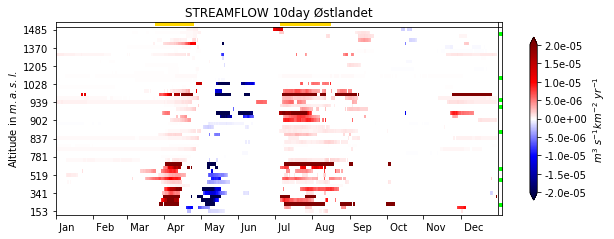

In [110]:
var = "streamflow"
reg = "ost"
MA = "10day"
file = findFiles(f"{var}_{reg}",MA,years=30,head="Ana")[0]
array = np.load(file)

df = annTrends30yr5a
AT = np.isnan(np.array(df[df.region=="ost"].runoff))
y = np.arange(array.shape[0]).astype(float)
x = np.full_like(y,366.5)
np.place(x,AT,np.nan)
np.place(y,AT,np.nan)

plotTrendMag(array,var,reg,MA,years=30,filename="testing",display=True,overrideColormap="seismic")
plt.savefig("Plots/FS_test.png",dpi=400)

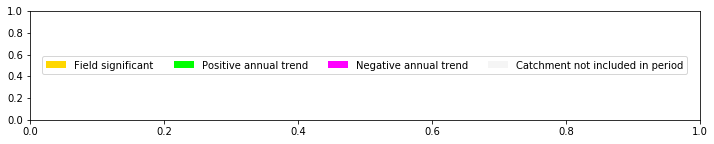

In [65]:
legend_elements = [Patch(facecolor="gold",label="Field significant"),
                   Patch(facecolor="lime",label="Positive annual trend"),
                   Patch(facecolor="magenta",label="Negative annual trend"),
                   Patch(facecolor="whitesmoke",label="Catchment not included in period")]
fig, ax = plt.subplots(figsize=(12,2))
ax.legend(handles=legend_elements, loc='center',ncol=4)
plt.savefig("Plots/Trends/dailyTrends_legend.png",dpi=400)

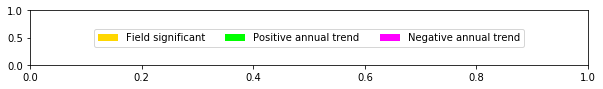

In [66]:
legend_elements = [Patch(facecolor="gold",label="Field significant"),
                   Patch(facecolor="lime",label="Positive annual trend"),
                   Patch(facecolor="magenta",label="Negative annual trend")]
fig, ax = plt.subplots(figsize=(10,1))
ax.legend(handles=legend_elements, loc='center',ncol=4)
plt.savefig("Plots/Trends/dailyTrends_legend2.png",dpi=400)

In [111]:
# 30 year trends
variables = ["snowmelt","rainfall","streamflow","temperature"]
averages = ["10day","5day","30day"]

for var in variables:
    for MA in averages:
        files = findFiles(var,MA,years=30,head="Ana")
        plotFiles(files,filename="30year/Analysis/trendResults_30year",years=30)

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: All-NaN axis encountered


Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 


In [112]:
for var in variables:
    for MA in averages:
        files = findFiles(var,MA,years=30,head="Mag")
        if var == "temperature":
            plotFiles(files,filename="30year/Magnitude/trendMagnitude_30year",years=30,colormap="seismic")
        else:
            plotFiles(files,filename="30year/Magnitude/trendMagnitude_30year",years=30,colormap="seismic_r")            

Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 


In [113]:
# 50 year trends
variables = ["rainfall","snowmelt","streamflow","temperature"]
averages = ["10day","5day","30day"]

for var in variables:
    for MA in averages:
        files = findFiles(var,MA,years=50,head="Ana")
        plotFiles(files,filename="50year/Analysis/trendResults_50year",years=50)

Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found

In [114]:
for var in variables:
    for MA in averages:
        files = findFiles(var,MA,years=50,head="Mag")
        if var == "temperature":
            plotFiles(files,filename="50year/Magnitude/trendMagnitude_50year",years=50,colormap="seismic")
        else:
            plotFiles(files,filename="50year/Magnitude/trendMagnitude_50year",years=50,colormap="seismic_r")

Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found

## Panel plots

In [71]:
regions = ("finn","nord","trond","vest","ost","sor")
variables = ("streamflow","snowmelt","rainfall","temperature")
head = "Ana"

sizes = [19, 34, 18, 61, 51, 24]
for MA in ["10day","5day","30day"]:
    for years in [30,50]:
        fig,ax = plt.subplots(nrows=6,ncols=4,figsize=(25,20),sharex=True,gridspec_kw={'height_ratios': sizes})
        for row in range(6):
            for col in range(4):
                region = regions[row]
                var = variables[col]
                file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
                arr = np.load(file)
                plotTrendMag(arr,var,region,MA,years,"",subplotting=True,ax=ax[row][col],overrideColormap="coolwarm")
        fig.text(0.05, 0.5, "Station ordered by altitude", va="center", rotation="vertical",fontsize=16)
        fig.text(0.22, 0.9, "Streamflow", ha="center", rotation="horizontal",fontsize=16)
        fig.text(0.5, 0.9, "Snowmelt", ha="center", rotation="horizontal",fontsize=16)
        fig.text(0.76, 0.9, "Rainfall", ha="center", rotation="horizontal",fontsize=16)
        plt.savefig(f"Plots/Trends/dailyTrend_allVariables_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
        plt.close()

Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:51: RuntimeWarning: All-NaN axis encountered


Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found

In [72]:
regions = ("finn","nord","trond","vest","ost","sor")
variables = ("streamflow","snowmelt","rainfall","temperature")
head = "Mag"

sizes = [19, 34, 18, 61, 51, 24]
for MA in ["10day","5day","30day"]:
    for years in [30,50]:
        fig,ax = plt.subplots(nrows=6,ncols=4,figsize=(25,20),sharex=True,gridspec_kw={'height_ratios': sizes})
        for row in range(6):
            for col in range(4):
                region = regions[row]
                var = variables[col]
                file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
                arr = np.load(file)
                plotTrendMag(arr,var,region,MA,years,"",subplotting=True,ax=ax[row][col],overrideColormap="seismic_r")
        fig.text(0.05, 0.5, "Station ordered by altitude", va="center", rotation="vertical",fontsize=16)
        fig.text(0.22, 0.9, "Streamflow", ha="center", rotation="horizontal",fontsize=16)
        fig.text(0.5, 0.9, "Snowmelt", ha="center", rotation="horizontal",fontsize=16)
        fig.text(0.76, 0.9, "Rainfall", ha="center", rotation="horizontal",fontsize=16)
        plt.savefig(f"Plots/Trends/dailyMagnitude_allVariables_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
        plt.close()

Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found. Plotting without FS... 
Field significance not found

In [73]:
regions = ("finn","nord","trond","vest","ost","sor")
variables = ("rainfall","snowmelt","streamflow","temperature")
years = [30,50]
MA = "10day"
head = "Ana"
sizes = [19, 34, 18, 61, 51, 24]

for var in variables:
    fig,ax = plt.subplots(nrows=6,ncols=2,figsize=(13,19),sharex=True,gridspec_kw={'height_ratios': sizes})
    for row in range(6):
        for col in range(2):
            region = regions[row]
            year = years[col]
            file = findFiles(f"{var}_{region}",MA,year,head=head)[0]
            arr = np.load(file)
            plotTrendMag(arr,var,region,MA,year,"",subplotting=True,ax=ax[row][col])
    fig.text(0.035, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
    fig.text(0.27, 0.9, "1983-2012", ha="center", rotation="horizontal",fontsize=16)
    fig.text(0.69, 0.9, "1963-2012", ha="center", rotation="horizontal",fontsize=16)
    plt.savefig(f"Plots/Trends/daily_{MA}_{var}.png",dpi=400,bbox_inches='tight')
    plt.close()

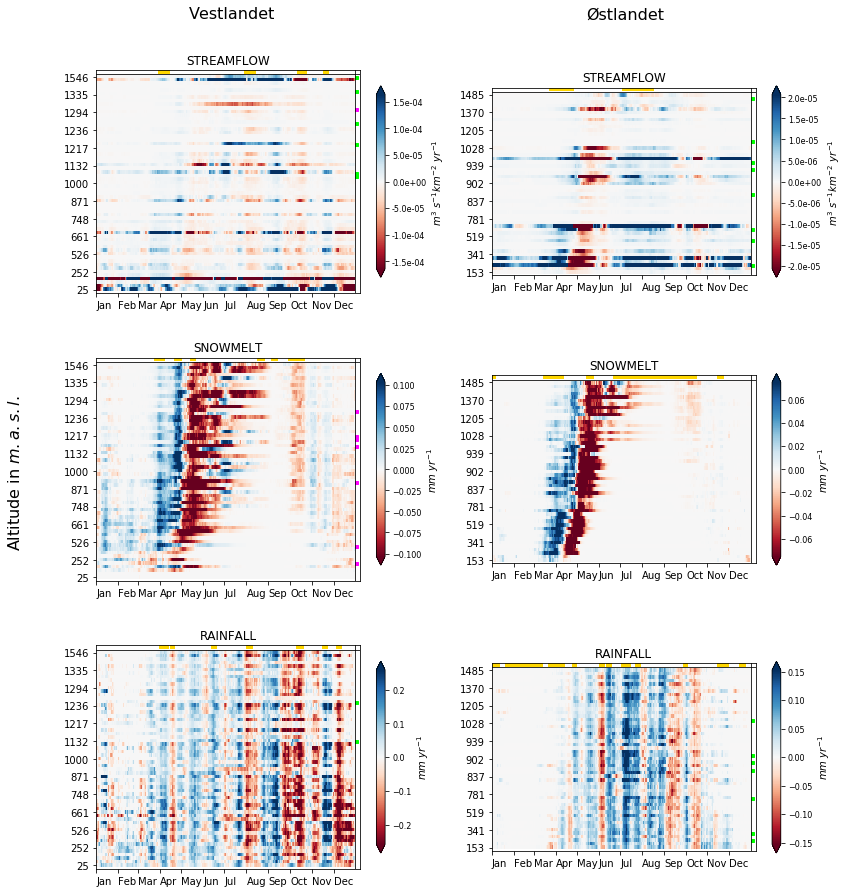

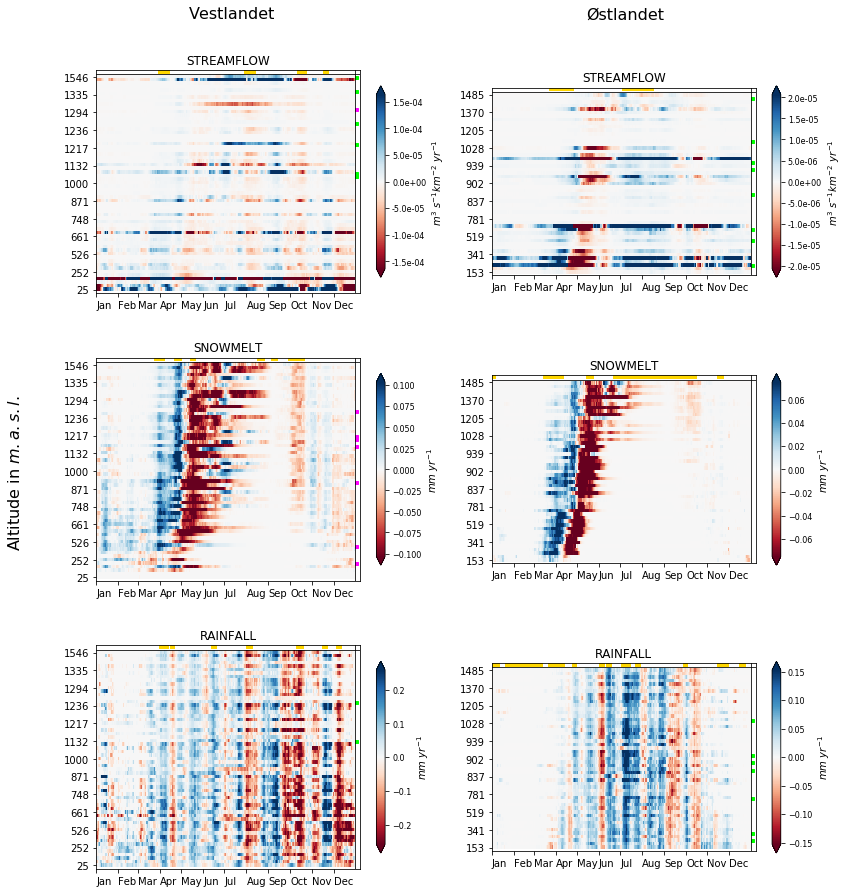

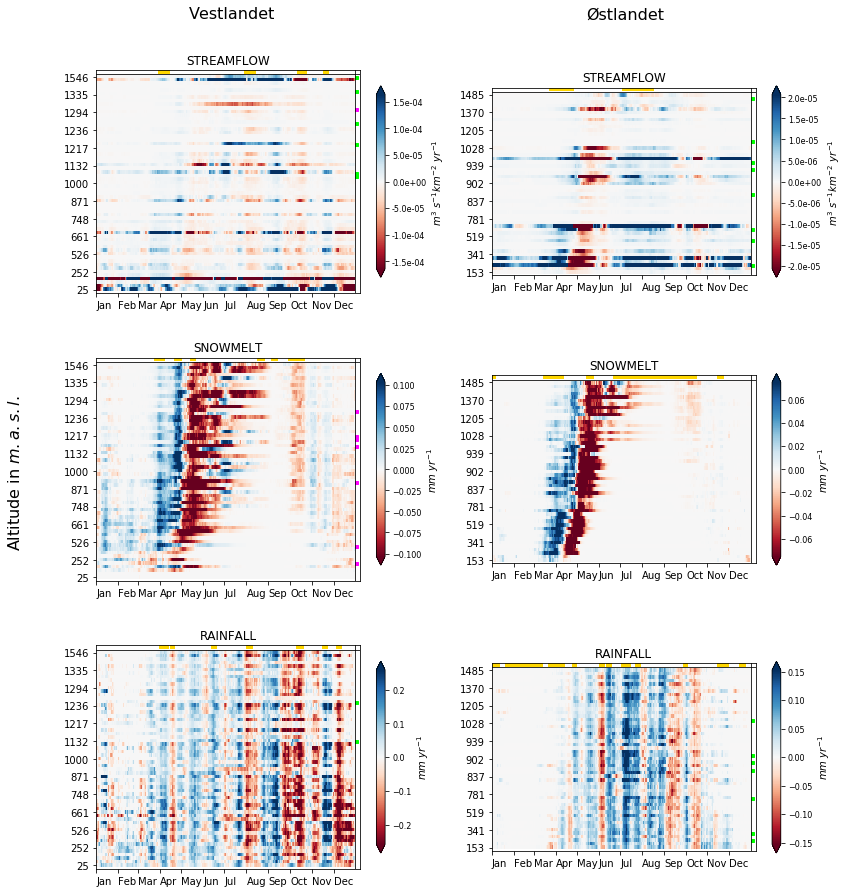

In [74]:
regions = ("vest","ost")
variables = ("streamflow","snowmelt","rainfall")
years = 30
MA = "10day"
head = "Mag"

for var in variables:
    fig,ax = plt.subplots(nrows=3,ncols=2,figsize=(13,15),sharey=False)
    for row in range(3):
        for col in range(2):
            region = regions[col]
            var = variables[row]
            file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
            arr = np.load(file)
            plotTrendMag(arr,var,region,MA,years,"",subplotting=True,ax=ax[row][col],overrideColormap="RdBu",titleOverride=var.upper())
    fig.text(0.03, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
    fig.text(0.27, 0.92, "Vestlandet", ha="center", rotation="horizontal",fontsize=16)
    fig.text(0.69, 0.92, "Østlandet", ha="center", rotation="horizontal",fontsize=16)
    plt.savefig(f"Plots/Trends/daily_OstVestComparison_{MA}.png",dpi=400,bbox_inches='tight')
    #plt.close()

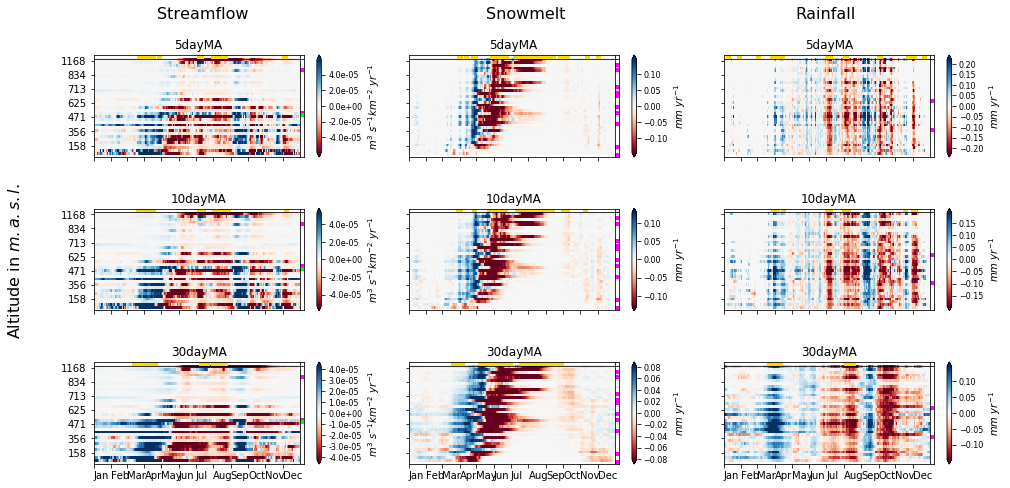

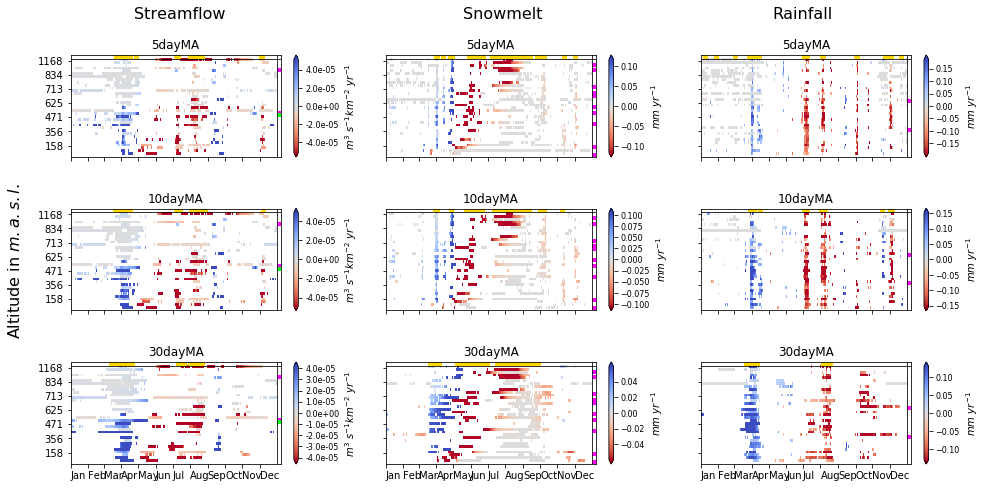

In [75]:
region = "nord"
variables = ("streamflow","snowmelt","rainfall")
years = 30
averages =["5day","10day","30day"]
head = "Mag"

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(16,8),sharey=True,sharex=True)
for row in range(3):
    for col in range(3):
        var = variables[col]
        MA = averages[row]
        file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
        arr = np.load(file)
        plotTrendMag(arr,var,region,MA,years,"",subplotting=True,ax=ax[row][col],overrideColormap="RdBu",titleOverride=f"{MA}MA")
fig.text(0.05, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
fig.text(0.22, 0.92, "Streamflow", ha="center", rotation="horizontal",fontsize=16)
fig.text(0.5, 0.92, "Snowmelt", ha="center", rotation="horizontal",fontsize=16)
fig.text(0.76, 0.92, "Rainfall", ha="center", rotation="horizontal",fontsize=16)
plt.savefig(f"Plots/MAcomparison_{head}_{years}year.png",dpi=400,bbox_inches='tight')

region = "nord"
variables = ("streamflow","snowmelt","rainfall")
years = 30
averages =["5day","10day","30day"]
head = "Ana"

fig,ax = plt.subplots(nrows=3,ncols=3,figsize=(16,8),sharey=True,sharex=True)
for row in range(3):
    for col in range(3):
        var = variables[col]
        MA = averages[row]
        file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
        arr = np.load(file)
        plotTrendMag(arr,var,region,MA,years,"",subplotting=True,ax=ax[row][col],titleOverride=f"{MA}MA")
fig.text(0.07, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
fig.text(0.22, 0.92, "Streamflow", ha="center", rotation="horizontal",fontsize=16)
fig.text(0.5, 0.92, "Snowmelt", ha="center", rotation="horizontal",fontsize=16)
fig.text(0.76, 0.92, "Rainfall", ha="center", rotation="horizontal",fontsize=16)
plt.savefig(f"Plots/MAcomparison_{head}_{years}year.png",dpi=400,bbox_inches='tight')

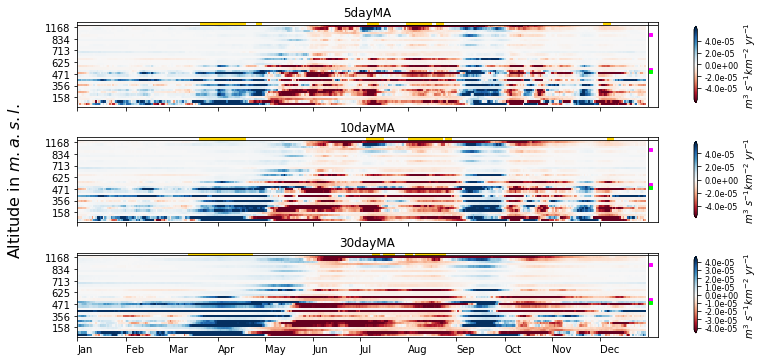

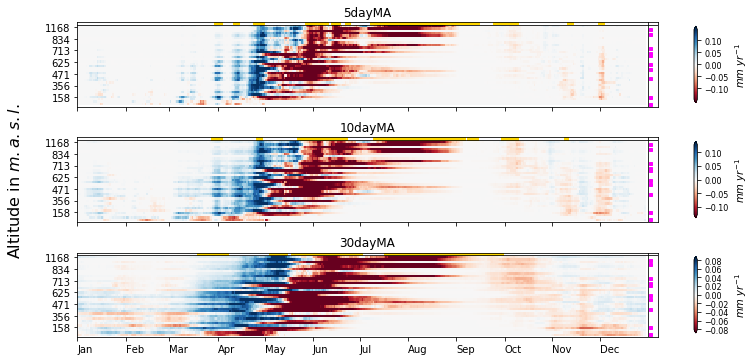

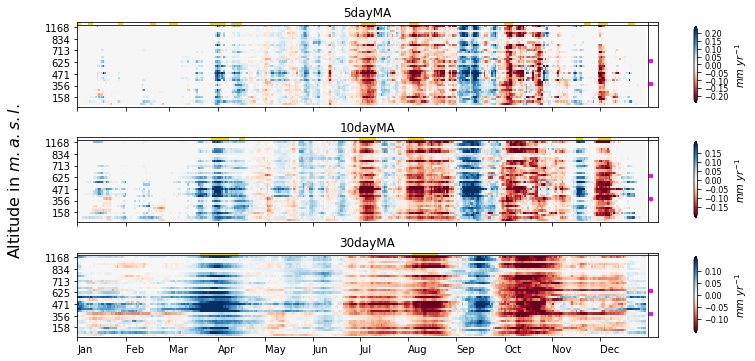

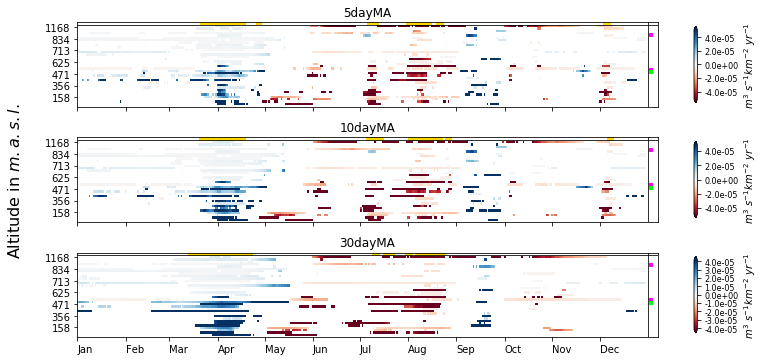

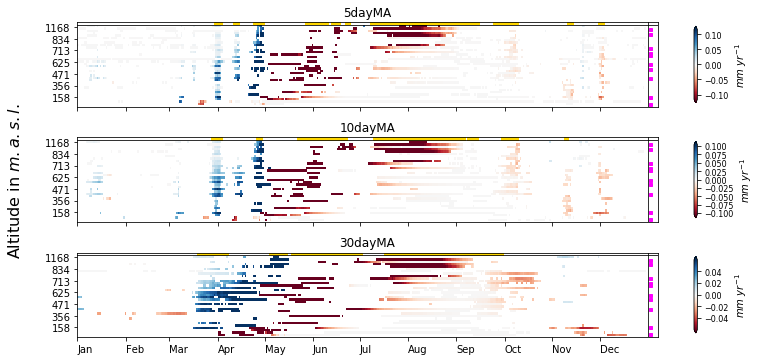

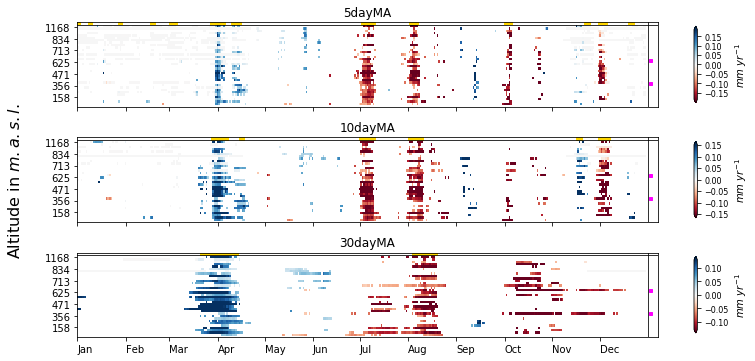

In [76]:
region = "nord"
variables = ("streamflow","snowmelt","rainfall")
years = 30
averages =["5day","10day","30day"]
head = "Mag"

for var in variables:
    fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(13,6),sharey=True,sharex=True)
    for row in range(3):
            MA = averages[row]
            file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
            arr = np.load(file)
            plotTrendMag(arr,var,region,MA,years,"",
                         subplotting=True,ax=ax[row],overrideColormap="RdBu",titleOverride=f"{MA}MA",overrideAspect=1.5)
    fig.text(0.05, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
    plt.savefig(f"Plots/MAcomparison2_{head}_{var}_{years}year.png",dpi=400,bbox_inches='tight')
    
head = "Ana"
for var in variables:
    fig,ax = plt.subplots(nrows=3,ncols=1,figsize=(13,6),sharey=True,sharex=True)
    for row in range(3):
            MA = averages[row]
            file = findFiles(f"{var}_{region}",MA,years,head=head)[0]
            arr = np.load(file)
            plotTrendMag(arr,var,region,MA,years,"",
                         subplotting=True,ax=ax[row],overrideColormap="RdBu",titleOverride=f"{MA}MA",overrideAspect=1.5)
    fig.text(0.05, 0.5, "Altitude in $m.a.s.l.$", va="center", rotation="vertical",fontsize=16)
    plt.savefig(f"Plots/MAcomparison2_{head}_{var}_{years}year.png",dpi=400,bbox_inches='tight')

## Line plots


### Temperature trends

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: Mean of empty slice


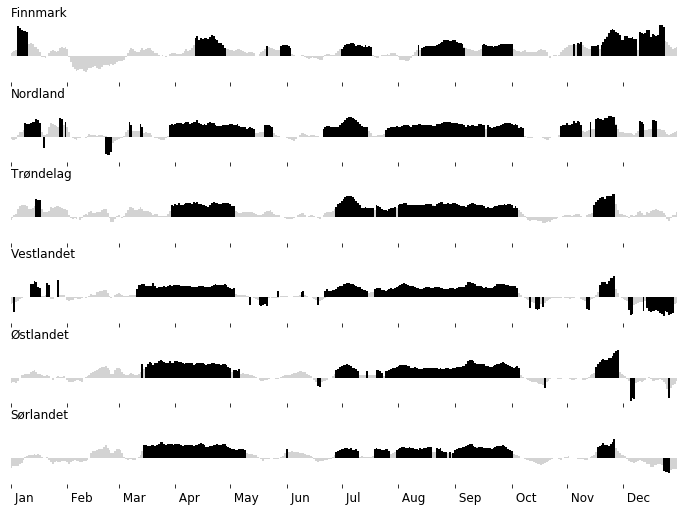

In [77]:
regions = ("finn","nord","trond","vest","ost","sor")
MA = "10day"
files = findFiles("temperature","10day",30,head="Ana")

x = np.arange(365)

fig,ax = plt.subplots(nrows=6,figsize=(10,7),sharex=True,sharey=True)
plt.tight_layout()
colors = itertools.cycle(("red","blue","green","yellow","black","grey"))
plt.xlim(0,365)
monthLoc = [0,31,59,90,120,151,181,212,243,274,304,335]
months = [" Jan"," Feb"," Mar"," Apr"," May"," Jun"," Jul"," Aug"," Sep"," Oct"," Nov"," Dec"]

for i in range(6):
    region = regions[i]
    file = findFiles(f"temperature_{region}",MA,30,head="Mag")[0]
    array = np.load(file)
    ax[i].bar(x,np.nanmean(array,axis=0),color="lightgrey",width=1)
    ax[i].set_title(f"{regionLabels[region]}",loc="left")
    
    file = findFiles(f"temperature_{region}",MA,30,head="Ana")[0]
    array = np.load(file)
    ax[i].bar(x,np.nanmean(array,axis=0),color="k",width=1)
    ax[i].set_title(f"{regionLabels[region]}",loc="left")
    
    ax[i].set_xticks(monthLoc) 
    ax[i].set_xticklabels(months, fontsize=12,ha="left")
    
    plt.setp(ax[i].get_xticklabels(), visible=True)
    plt.setp(ax[i].get_yticklabels(), visible=False)
    plt.setp(ax[i].get_xticklines(), visible=True)
    plt.setp(ax[i].get_yticklines(), visible=False)
    plt.setp(ax[i].spines.values(), visible=False)

plt.savefig(f"Plots/Trends/mean_temperature_{MA}_trends.png",dpi=400,bbox_inches='tight')

### Catchment plots

In [78]:
def catchmentLinePlot(data,region,MA,years,catchments = None, display = False):

    file = findFiles(f"streamflow_{region}",MA,years,head="Mag")[0]
    stream = np.load(file)
    file = findFiles(f"rainfall_{region}",MA,years,head="Mag")[0]
    rain = np.load(file)
    file = findFiles(f"snowmelt_{region}",MA,years,head="Mag")[0]
    snow = np.load(file)
    file = findFiles(f"temperature_{region}",MA,years,head="Ana")[0]
    temp = np.load(file)
    
    snumber = data[f"final30"]
    
    if years == 30:
        ANN = annTrends30yr5a
        ANNtemp = annTempTrends30yr5a
    elif years == 50:
        ANN = annTrends50yr5a
        ANNtemp = annTempTrends50yr5a

    monthLoc = [0,31,59,90,120,151,181,212,243,274,304,335]
    months = [" Jan"," Feb"," Mar"," Apr"," May"," Jun"," Jul"," Aug"," Sep"," Oct"," Nov"," Dec"]

    if catchments==None:
        catchments = np.arange(len(snumber))
    
    for c in catchments:
        if (temp[c,:]==-99).all():
            continue
        
        fig, ax1 = plt.subplots(figsize=(10,3))
        plt.xlim(0,365)
        plt.xticks(monthLoc, months, fontsize=12,ha="left") 
        
        arr = temp[c,:]
        index = np.where(arr>0)[0]
        plt.vlines(index,ymin=-10,ymax=10,color="whitesmoke",linewidth=3,label="Sign. pos. temperature trend")
        
        s = stream[c,:]
        ax1.plot(s,"k",label="Streamflow trend")
        lim = np.array([-np.nanmin(s),np.nanmax(s)]).max()*1.1
        ax1.set_ylim(-lim,lim)
        ax1.set_ylabel("Streamflow trend magnitude\n$m^3\ s^{-1}\ km^{-2}\ yr^{-1}$")

        ax2 = ax1.twinx()
        both = snow[c,:]+rain[c,:]
        ax2.plot(snow[c,:],":",color="grey",label="Snowmelt trend")
        ax2.plot(rain[c,:],":",color="skyblue",label="Rainfall trend")
        ax2.plot(both,"b--",label="Rainfall+snowmelt trend")
        lim = np.array([-np.nanmin(both),np.nanmax(both)]).max()*1.1
        ax2.set_ylim(-lim,lim)
        ax2.set_ylabel("Trend magnitude ($mm\ yr^{-1}$)\nRainfall and snowmelt")
        ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1e'))
        
        alt = int(altitudes[region][c])
        catchm = snumber[c]
        annRunoffTrend = float(ANN.runoff[ANN.snumber==catchm])
        annTempTrend = float(ANNtemp["Ttrend_deg/yr"][ANNtemp.snumber==catchm])
        
        if np.isfinite(annRunoffTrend):
            plt.title(f"Annual runoff trend: {annRunoffTrend:.2f} $mm\ yr^{-1}$",fontsize=10, loc="left")
        if np.isfinite(annTempTrend):
            plt.title(f"Annual temperature trend: {annTempTrend:.2f} {units['temperature']}",fontsize=10, loc="right")
        
        plt.savefig(f"Plots/Trends/Selected/{years}yearTrends_{MA}_{region}_{snumber[c]}.png",dpi=400,bbox_inches='tight')
    
        if not display:
            plt.close()

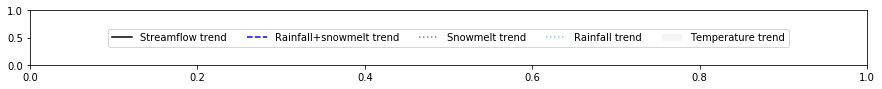

In [79]:
legend_elements = [Line2D([0], [0], color="k",label="Streamflow trend"),
                           Line2D([0], [0], linestyle="--", color="b",label="Rainfall+snowmelt trend"),
                           Line2D([0], [0], linestyle=":", color="grey",label="Snowmelt trend"),
                           Line2D([0], [0], linestyle=":", color="skyblue",label="Rainfall trend"),
                           Patch(facecolor="whitesmoke",label="Temperature trend")]
plt.figure(figsize=(15,1))
plt.legend(handles=legend_elements,ncol=5,loc="center")
plt.savefig("Plots/Trends/Selected/legend.png",dpi=400)

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


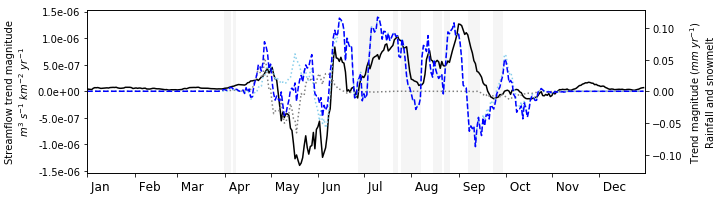

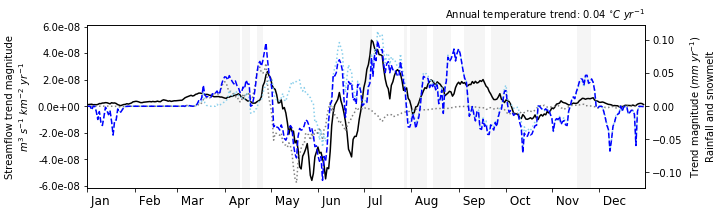

In [80]:
catchmentLinePlot(data=ost,
                  region = "ost",
                  MA = "10day",
                  years = 30,catchments=(10,12),display=True)

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in greater


TypeError: cannot convert the series to <class 'float'>

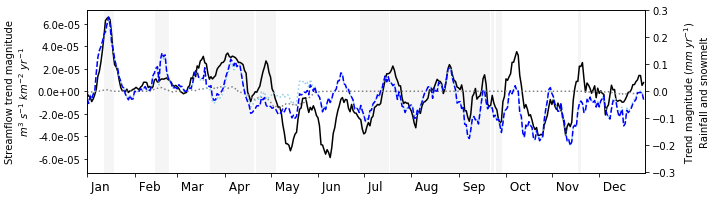

In [81]:
catchmentLinePlot(data=ost,
                  region = "ost",
                  MA = "10day",
                  years = 30)

catchmentLinePlot(data=vest,
                  region = "vest",
                  MA = "10day",
                  years = 30)

catchmentLinePlot(data=ost,
                  region = "ost",
                  MA = "10day",
                  years = 50)

catchmentLinePlot(data=vest,
                  region = "vest",
                  MA = "10day",
                  years = 50)

catchmentLinePlot(data=finn,
                  region = "finn",
                  MA = "10day",
                  years = 30)

## Hydrographs
* Calculate hydrograph for catchment based on 5 years before trend analysis
* Extract "trend hydrograph" from trend magnitude array
* Calculate "new" hydrograph

In [84]:
def plotHydrographs(MA, region, data, years, save=True, display=False):

    file = findFiles(MA=MA,variable=f"streamflow_{region}",years=years,head="Mag")[0]
    arr = np.load(file)

    for c in range(len(data[f"final{years}"])):
        catchment = data[f"final{years}"][c]

        area = data["metadata"][data["metadata"].snumber==catchment].areal.iloc[0]
        """if MA == "5day":
            ts = (data["data"][catchment]["runoff"]["1973":"1982"].runoff/area).rolling(5).mean()
        if MA == "10day":
            ts = (data["data"][catchment]["runoff"]["1973":"1982"].runoff/area).rolling(10).mean()
        if MA == "30day":
            ts = (data["data"][catchment]["runoff"]["1973":"1982"].runoff/area).rolling(30).mean()"""
        ts = (data["data"][catchment]["runoff"]["1973":"1982"].runoff/area)
        tsg = ts.groupby([ts.index.month,ts.index.day])
        means = []
        for name, group in tsg:
            means.append((group.mean()))
        HG = np.array(means[:-1])

        trendHG = arr[c,:]*years

        try:
            newHG = HG + trendHG
        except ValueError:
            newHG = HG + trendHG[:-1]


        monthLoc = [0,31,59,90,120,151,181,212,243,274,304,335]
        months = [" Jan"," Feb"," Mar"," Apr"," May"," Jun"," Jul"," Aug"," Sep"," Oct"," Nov"," Dec"]

        plt.figure(figsize=(10,4))
        plt.hlines(0,0,365,color="whitesmoke")
        plt.plot(HG,"k",label="Original hydrograph")
        plt.plot(trendHG,"r",label="Daily trend graph")
        plt.plot(newHG,"b--",label="New hydrograph")
        plt.legend()
        plt.xlim(0,365)
        plt.xticks(monthLoc, months, fontsize=12,ha="left") 
        plt.ylabel("Specific streamflow ($m^3\ s^{-1}\ km^{-2} $)")
        plt.title(f"{altitudes[region].astype(int)[c]} m.a.s.l.",loc="right")
        plt.title(f"{catchment} {regionLabels[region]}",loc="center")
        plt.title(f"{area:.0f} $km^2$",loc="left")

        if save:
            plt.savefig(f"Plots/Hydrographs/hydrograph_{years}year_{MA}_{region}_{catchment}.png",dpi=400,bbox_inches='tight')
        if not display:
            plt.close()

In [86]:
plotHydrographs("10day","ost",ost,30)
plotHydrographs("10day","vest",vest,30)
plotHydrographs("10day","finn",finn,30)

## Trend timing

In [87]:
def consecutive(data, stepsize=1):
    """
    This function has been taken directly from:
    https://stackoverflow.com/questions/7352684/how-to-find-the-groups-of-consecutive-elements-from-an-array-in-numpy
    by
    unutbu
    https://stackoverflow.com/users/190597/unutbu
    """
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def trendTiming(arr):
    """
    Calculates the trend timing according to Kormann et al. (2015)
    https://doi.org/10.2166/wcc.2014.099
    """
    index = np.where(np.isfinite(arr))[0]
    clusters = consecutive(index)
    
    timing = []
    for cluster in clusters:
        magnitudes = arr[cluster]
        moment = (magnitudes*cluster).sum()/magnitudes.sum()
        timing.append(moment)
    
    return timing

def trendTimingMinMax(arr):
    """
    Finds the central moment of trend cluster with minimum and maximum magnitude.
    
    Returns
    -------
    (timingMax,timingMin)
        tuple of trend timing for max and min
    """
    t = np.round(trendTiming(arr)).astype(int)
    mag = arr[t]
    imax = mag.argmax()
    imin = mag.argmin()
    return t[imax],t[imin]

In [88]:
def plotTrendClusters(Sarr,NSarr,subplotting=False,ax=None,colormap="cividis",size=None,var=None):
    N = Sarr.shape[0]
    cmap = plt.cm.get_cmap(colormap)
    norm = matplotlib.colors.Normalize(vmin=0,vmax=N)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
    
    if subplotting:
        #for c in range(N):
            #ax.plot(NSarr[c,:],"--",linewidth=1,alpha=0.5)
        for c in range(N):
            ax.plot(Sarr[c,:],linewidth=2,alpha=0.5)
    else:
        plt.figure(figsize=size)
        #plt.title("Trend magnitude",loc="right")
        plt.ylabel(f"Trend magnitude ({units[var]})")
        plt.xlabel("DOY")
        plt.axhline(0,color="grey")
        plt.xlim(0,365)
        for c in range(N):
            plt.plot(NSarr[c,:],"--",linewidth=1,alpha=0.5)
        for c in range(N):
            plt.plot(Sarr[c,:],linewidth=2,alpha=0.5)
        cbar = plt.colorbar(sm,label="Station by altitude")
        cbar.ax.invert_yaxis()

In [89]:
def plotPosNegTrendTiming(arr,altitudes,subplotting=False,ax=None):
    cmap = plt.cm.get_cmap("cividis",2)
    pos = cmap(0)
    neg = "goldenrod"
    if subplotting:
        for c in range(arr.shape[0]):
            subArr = arr[c,:]
            x = np.round(trendTiming(subArr)).astype(int)
            x = np.delete(x,np.where(x<0))
            y = altitudes[c]
            for i in range(len(x)):
                t = x[i]
                if subArr[t]>0:
                    ax.plot(x[i],y,"^",color=pos)
                else:
                    ax.plot(x[i],y,"v",color=neg)
    else:
        plt.figure()
        plt.xlim(0,365)
        plt.title("Trend timing",loc="right")
        plt.xlabel("DOY")
        plt.ylabel("Altitude in $m.a.s.l.$")
        for c in range(arr.shape[0]):
            subArr = arr[c,:]
            x = np.round(trendTiming(subArr)).astype(int)
            x = np.delete(x,np.where(x<0))
            y = altitudes[c]
            for i in range(len(x)):
                t = x[i]
                if subArr[t]>0:
                    plt.plot(x[i],y,"^",color=pos)
                else:
                    plt.plot(x[i],y,"v",color=neg)

In [90]:
def subplotTrendClusterTiming(Sstream,Ssnow,Srain,NSstream,NSsnow,NSrain,region,MA,years):
    fig,ax = plt.subplots(nrows=2,ncols=3,sharex=True,figsize=(15,7))
    # streamflow
    plotTrendClusters(Sstream,NSstream,subplotting=True,ax=ax[0][0])
    plotPosNegTrendTiming(Sstream,altitudes[region],subplotting=True,ax=ax[1][0])
    # snowmelt
    plotTrendClusters(Ssnow,NSsnow,subplotting=True,ax=ax[0][1])
    plotPosNegTrendTiming(Ssnow,altitudes[region],subplotting=True,ax=ax[1][1])
    # rainfall
    plotTrendClusters(Srain,NSrain,subplotting=True,ax=ax[0][2])
    plotPosNegTrendTiming(Srain,altitudes[region],subplotting=True,ax=ax[1][2])
    # labels
    ax[0][0].set_ylabel("Trend Magnitude")
    ax[1][0].set_ylabel("Altitude in $m.a.s.l.$")
    ax[0][0].set_title("Streamflow")
    ax[0][1].set_title("Snowmelt")
    ax[0][2].set_title("Rainfall")
    ax[1][1].set_xlabel("DOY")
    
    N = Sstream.shape[0]
    cmap = plt.cm.cividis
    norm = matplotlib.colors.Normalize(vmin=0,vmax=N)
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    sm.set_array([])
    
    cmap = plt.cm.get_cmap("cividis",2)
    pos = cmap(0)
    neg = "goldenrod"
    legend_elements = [Line2D([0], [0], marker='^', color='w', label="Positive",markerfacecolor=pos, markersize=10),
                       Line2D([0], [0], marker='v', color='w', label="Negative",markerfacecolor=neg, markersize=10),
                       Line2D([0], [0], marker='^', color='w', label="cluster",markerfacecolor="w", markersize=10)]
    ax[1][2].legend(handles=legend_elements, loc="right",bbox_to_anchor=(1.4, 0.5),title="Trend timing of")
    
    cbar_ax = fig.add_axes([0.92, 0.55, 0.01, 0.3])
    cbar = fig.colorbar(sm,cax=cbar_ax,label=f"Station by altitude")
    cbar.ax.invert_yaxis()
    # save plot
    plt.savefig(f"Plots/TrendTiming_{years}year_{MA}_{region}.png",dpi=400,bbox_inches='tight')

In [91]:
def findPlotSave(region,MA,years):
    file = findFiles(head="Ana",variable=f"streamflow_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    Sstream = arr
    
    file = findFiles(head="Mag",variable=f"streamflow_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    NSstream = arr

    file = findFiles(head="Ana",variable=f"snowmelt_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    Ssnow = arr
    
    file = findFiles(head="Mag",variable=f"snowmelt_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    NSsnow = arr

    file = findFiles(head="Ana",variable=f"rainfall_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    Srain = arr
    
    file = findFiles(head="Mag",variable=f"rainfall_{region}",MA=MA,years=years)[0]
    arr = np.load(file)
    np.place(arr,arr==-99,np.nan)
    NSrain = arr

    subplotTrendClusterTiming(Sstream,Ssnow,Srain,NSstream,NSsnow,NSrain,region,MA=MA,years=years)

In [92]:
def findPlotSingle(region,var,MA,years,size=None,savefile=False,display=False):
    Sfile = findFiles(head="Ana",variable=f"{var}_{region}",MA=MA,years=years)[0]
    NSfile = findFiles(head="Mag",variable=f"{var}_{region}",MA=MA,years=years)[0]

    Sarr = np.load(Sfile)
    np.place(Sarr,Sarr==-99,np.nan)
    NSarr = np.load(NSfile)
    np.place(NSarr,NSarr==-99,np.nan)

    plotTrendClusters(Sarr,NSarr,size=(10,5),var=var)
    
    if savefile:
        plt.savefig(f"Plots/Trends/Line/TrendLine_{region}_{var}_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
    
    if not display:
        plt.close()

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


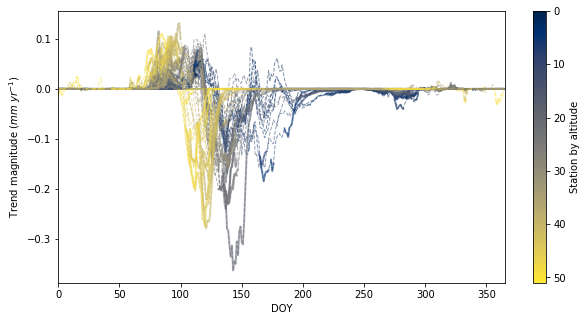

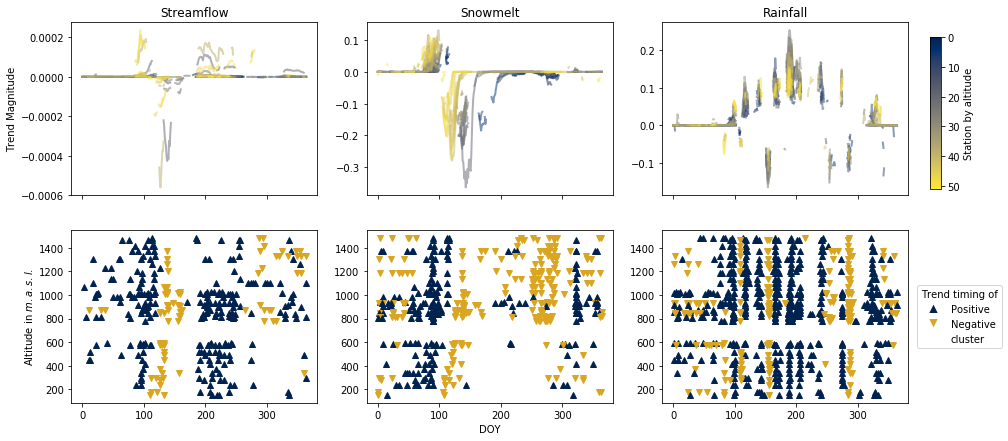

In [93]:
findPlotSingle("ost","snowmelt","10day",30,display=True,savefile=False)
findPlotSave("ost","10day",30)

In [94]:
years=[30,50]
regions=["vest","ost","nord","sor","trond","finn"]

for year in years:
    for region in regions:
        for var in ["streamflow","snowmelt","temperature","rainfall"]:
            findPlotSingle(region,var,"10day",year,savefile=True)

In [95]:
years=[30,50]
regions=["vest","ost","nord","sor","trond","finn"]

for year in years:
    for region in regions:
        for MA in ["5day","10day","30day"]:
            findPlotSave(region,MA,year)
            plt.close()

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


## Altitude dependence

In [131]:
def plotAltMag(region,var,MA,years,withMinMax=False,subplotting=False,ax=None,legend=False,head="Ana"):
    file = findFiles(head=head,variable=f"{var}_{region}",MA=MA,years=years)[0]
    array = np.load(file)
    
    height = array.shape[0]/10
    
    mask = np.unique(np.where(array!=-99)[0])
    array = array[mask,:]
    
    alt = altitudes[region][mask]
    
    m = np.nanmean(array,axis=1)
    s = np.nanstd(array,axis=1)
    
    mini = []
    maxi = []
    for c in range(array.shape[0]):
        mini.append(np.nanmin(array[c,:]))
        maxi.append(np.nanmax(array[c,:]))
    
    if subplotting:
        ax.axvline(0,color="k",linewidth=1)
        
        if withMinMax:
            ax.fill_betweenx(alt,mini,maxi,color="lightgrey",alpha=0.5,label="Minimum-maximum values")
        
        ax.fill_betweenx(alt,m-s,m+s,color="grey",alpha=0.5,label="Standard deviation")

        ax.plot(m,alt,"b-",label="Mean")
        ax.set_title(f"n = {array.shape[0]}")
        ax.set_ylabel(regionLabels[region],fontsize=14)
        #ax.set_ylim(0,alt.max())
        
        if var == "streamflow":
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
        
        if legend:
            ax.legend(loc="best")
    else:
        plt.figure(figsize=(5,height))
        plt.vlines(0,ymin=0,ymax=alt.max(),color="k",linewidth=1)
        plt.ylim(0,alt.max())
        if withMinMax:
            plt.fill_betweenx(alt,mini,maxi,color="lightgrey",alpha=0.5,label="Minimum-maximum values")

        plt.fill_betweenx(alt,m-s,m+s,color="grey",alpha=0.5,label="Standard deviation")

        plt.plot(m,alt,"b-",label="Mean")
        plt.title(regionLabels[region])
        plt.xlabel(f"Trend magnitude ({units[var]})")
        plt.ylabel("Altitude in $m.a.s.l.$")
        if legend:
            plt.legend(loc="best")

In [97]:
regions = ("finn","nord","trond","vest","ost","sor")
averages = ["5day","10day","30day"]

for var in ["snowmelt","streamflow","rainfall","temperature"]:
    for MA in averages:
        for years in [30,50]:
            if var == "streamflow":
                fig,ax = plt.subplots(nrows=3,ncols=2,sharex=False,sharey=False,figsize=(6,7))
            else:
                fig,ax = plt.subplots(nrows=3,ncols=2,sharex=True,sharey=False,figsize=(6,7))
            axes = [ax[0][0],ax[0][1],ax[1][0],ax[1][1],ax[2][0],ax[2][1]]
            
            for i in range(len(regions)):
                region = regions[i]
                plotAltMag(region,var,MA,years,subplotting=True,ax=axes[i],withMinMax=True)
            
            plt.tight_layout(pad=0.8)
            
            fig.text(0.5, -0.02, f"Trend magnitude ({units[var]})", ha='center',fontsize=14)
            fig.text(-0.02, 0.5, "Altitude in $m.a.s.l.$", va='center', rotation='vertical',fontsize=14)
            
            plt.savefig(f"Plots/altitude_trendMag_{var}_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
            plt.close()

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/skam2905/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered


In [98]:
def plotAltMagPercentile(region,var,q,MA="10day",years=30,ax=None,head="Ana"):
    file = findFiles(head=head,variable=f"{var}_{region}",MA=MA,years=years)[0]
    array = np.load(file)
    
    mask = np.unique(np.where(array!=-99)[0])
    array = array[mask,:]
    
    alt = altitudes[region][mask]

    high = np.nanpercentile(array,q,axis=1)
    reg = stats.linregress(alt,high)
    x = np.linspace(alt.min(),alt.max())
    
    
    if ax:
        ax.plot(high,alt,"kx")
        
        if reg.pvalue<0.05:
            ax.plot(x*reg.slope+reg.intercept,x,color="k")
            mod = alt*reg.slope+reg.intercept
            R = ((mod-high)**2).mean()
            if var == "streamflow":
                ax.set_title(f"$RMSE$ = {R:.1e}",loc="right")
            else:
                ax.set_title(f"$RMSE$ = {R:.4f}",loc="right")
        else:
            ax.plot(x*reg.slope+reg.intercept,x,"--",color="grey")
            mod = alt*reg.slope+reg.intercept
            R = ((mod-high)**2).mean()
            if var == "streamflow":
                ax.set_title(f"$RMSE$ = {R:.2e}",loc="right",color="grey")
            else:
                ax.set_title(f"$RMSE$ = {R:.4f}",loc="right",color="grey")
        
        if (region == "vest" or region=="ost") and (var=="snowmelt" or var=="rainfall"):
            p = np.polyfit(alt,high,2)
            mod = p[0]*alt**2+p[1]*alt+p[2]
            RMSE = ((mod-high)**2).mean()
            y = np.linspace(alt.min(),alt.max())
            ax.plot(p[0]*y**2+p[1]*y+p[2],y,color="r")
            if var == "streamflow":
                ax.set_title(f"$RMSE$ = {RMSE:.2e}",loc="left",color="r")
            else:
                ax.set_title(f"$RMSE$ = {RMSE:.4f}",loc="left",color="r")
        
        if var == "streamflow":
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.0e'))
        
        if region=="finn":
            ax.set_title(f"{q}th percentile", loc="left")
        
    else:
        plt.figure()
        plt.plot(high,alt,"kx")
        
        if reg.pvalue<0.05:
            plt.plot(x*reg.slope+reg.intercept,x,color="k")
            mod = alt*reg.slope+reg.intercept
            R = ((mod-high)**2).mean()
            if var == "streamflow":
                plt.title(f"$RMSE$ = {R:.1e}",loc="right")
            else:
                plt.title(f"$RMSE$ = {R:.4f}",loc="right")
        else:
            plt.plot(x*reg.slope+reg.intercept,x,"--",color="grey")
            mod = alt*reg.slope+reg.intercept
            R = ((mod-high)**2).mean()
            if var == "streamflow":
                plt.title(f"$RMSE$ = {R:.1e}",loc="right",color="grey")
            else:
                plt.title(f"$RMSE$ = {R:.4f}",loc="right",color="grey")
        
        if (region == "vest" or region=="ost") and (var=="snowmelt" or var=="rainfall"):
            p = np.polyfit(alt,high,2)
            mod = p[0]*alt**2+p[1]*alt+p[2]
            RMSE = ((mod-high)**2).mean()
            y = np.linspace(alt.min(),alt.max())
            plt.plot(p[0]*y**2+p[1]*y+p[2],y,color="r")
            if var == "streamflow":
                plt.title(f"$RMSE$ = {RMSE:.1e}",loc="left",color="r")
            else:
                plt.title(f"$RMSE$ = {RMSE:.4f}",loc="left",color="r")
        
        plt.xlabel(units[var])
        plt.title(regionLabels[region])

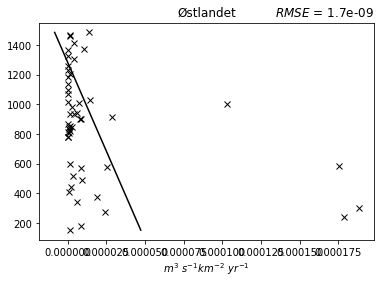

In [99]:
plotAltMagPercentile("ost","streamflow",95)

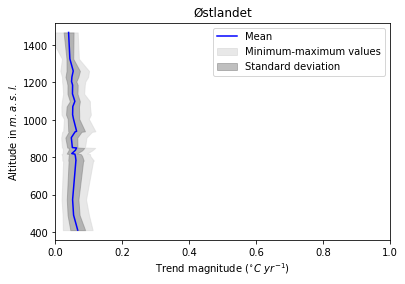

In [100]:
plotAltMag("ost",var,MA,years,legend=True,withMinMax=True)
plt.xlim(0,1)
plt.savefig(f"Plots/altitude_legend",dpi=400,bbox_inches='tight')

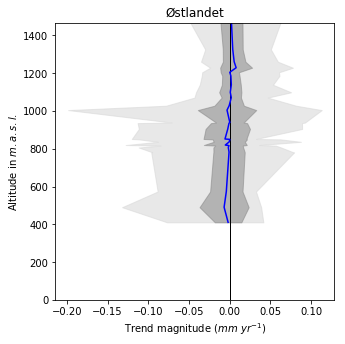

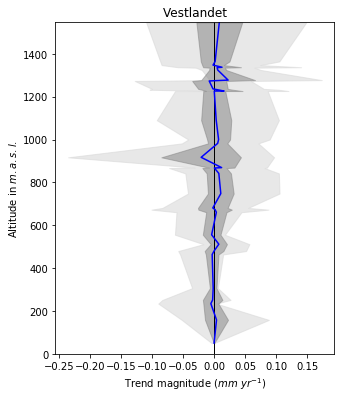

In [133]:
plotAltMag("ost","snowmelt","10",50,withMinMax=True,legend=False,head="Mag")
plt.savefig(f"Plots/altitude_special_ost_snowmelt_10day_50year.png",dpi=400,bbox_inches='tight')
plotAltMag("vest","snowmelt","10",50,withMinMax=True,legend=False,head="Mag")
plt.savefig(f"Plots/altitude_special_vest_snowmelt_10day_50year.png",dpi=400,bbox_inches='tight')

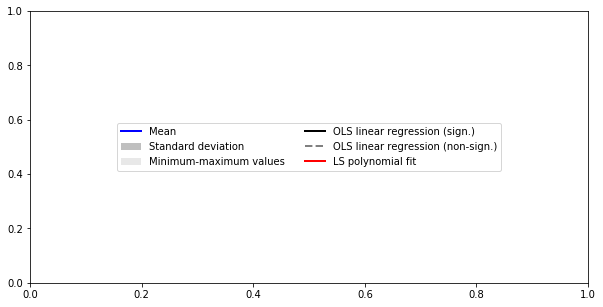

In [101]:
legend_elements = [Line2D([0], [0], color='b', lw=2, label="Mean"),
                   Patch(facecolor="grey",label="Standard deviation",alpha=0.5),
                   Patch(facecolor="lightgrey",alpha=0.5,label="Minimum-maximum values"),
                   Line2D([0], [0], color='k', lw=2, label="OLS linear regression (sign.)"),
                   Line2D([0], [0], color='grey',linestyle="--", lw=2, label="OLS linear regression (non-sign.)"),
                   Line2D([0], [0], color='red',linestyle="-", lw=2, label="LS polynomial fit")]
fig, ax = plt.subplots(figsize=(10,5))
ax.legend(handles=legend_elements, loc='center',ncol=2)
plt.savefig("Plots/Trends/altitude_legend2.png",dpi=400)

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: All-NaN slice encountered
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: RuntimeWarning: All-NaN slice encountered


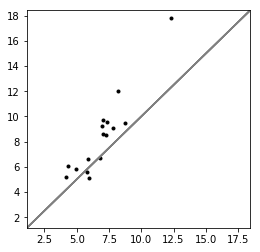

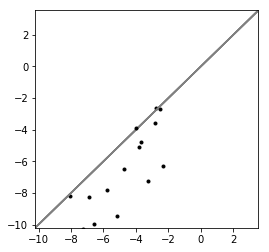

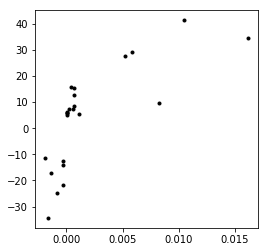

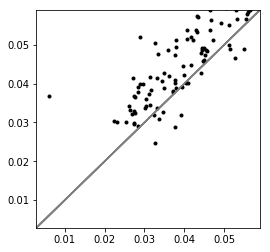

In [102]:
def AnnualvsDailyTrendSum(var,ax=None,years=30,head="Mag"):
    regions = ("finn","nord","trond","vest","ost","sor")
    if years==30:
        annTrends = annTrends30yr5a
        annTempTrends = annTempTrends30yr5a
    elif years==50:
        annTrends = annTrends50yr5a
        annTempTrends = annTempTrends50yr5a
    plt.figure(figsize=(4,4))
    for region in regions:
        file = findFiles(head=head,variable=f"{var}_{region}",MA=MA,years=years)[0]
        array = np.load(file)
        mask = np.unique(np.where(array!=-99)[0])
        array = array[mask,:]
        alt = altitudes[region][mask]
        dailySum = np.nansum(array,axis=1)
        
        if var == "temperature":
            ANN = np.array(annTempTrends["Ttrend_deg/yr"][annTempTrends.region==region])
            dailySum = np.nanmean(array,axis=1)
        elif var == "streamflow":
            ANN = np.array(annTrends["runoff"][annTrends.region==region])
        else:
            ANN = np.array(annTrends[var][annTrends.region==region])
        
        mini = np.nanmin([np.nanmin(ANN),np.nanmin(dailySum)])
        maxi = np.nanmax([np.nanmax(ANN),np.nanmax(dailySum)])
        
        
        if var!="streamflow":
            plt.plot([-30,30],[-30,30],color="grey")
            plt.xlim(mini,maxi)
            plt.ylim(mini,maxi)
        plt.plot(dailySum,ANN,"k.")
         
        if ax:
            ax.plot(dailySum,ANN,"k.")
            ax.set_ylabel("Daily trend sum")
            ax.set_xlabel("Annual trend")

AnnualvsDailyTrendSum("rainfall")
AnnualvsDailyTrendSum("snowmelt")
AnnualvsDailyTrendSum("streamflow")
AnnualvsDailyTrendSum("temperature")

In [103]:
def dailyTrendSumvsAltitude(region,MA="10day",years=30,head="Mag",ax=None):
    file = findFiles(head=head,variable=f"{var}_{region}",MA=MA,years=years)[0]
    array = np.load(file)

    mask = np.unique(np.where(array!=-99)[0])
    array = array[mask,:]

    alt = altitudes[region][mask]
    dailyTrendSum = np.nansum(array,axis=1)
    reg = stats.linregress(alt,dailyTrendSum)
    x = np.linspace(alt.min(),alt.max())
    
    if ax:
        ax.plot(dailyTrendSum,alt,".",color="green")
        ax.plot(x*reg.slope+reg.intercept,x,"-",color="green")
    else:
        plt.plot(dailyTrendSum,alt,".",color="green")
        plt.plot(x*reg.slope+reg.intercept,x,"-",color="green")

In [104]:
regions = ("finn","nord","trond","vest","ost","sor")

for var in ["snowmelt","streamflow","rainfall","temperature"]:
    for MA in averages:
        for years in [30,50]:

            fig,ax = plt.subplots(nrows=len(regions),ncols=3,sharex=False,sharey=True,figsize=(10,15))
            
            for row in range(len(regions)):
                region = regions[row]
                plotAltMag(region,var,MA,years,subplotting=True,ax=ax[row][0],withMinMax=True)
                plotAltMagPercentile(region,var,5,ax=ax[row][1],years=years,MA=MA)
                plotAltMagPercentile(region,var,95,ax=ax[row][2],years=years,MA=MA)
            
            plt.tight_layout(pad=0.8)
            
            fig.text(0.5, -0.02, f"Trend magnitude ({units[var]})", ha='center',fontsize=14)
            fig.text(-0.02, 0.5, "Altitude in $m.a.s.l.$", va='center', rotation='vertical',fontsize=14)
            
            plt.savefig(f"Plots/altitude_trendMag_{var}_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
            plt.close()

/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/skam2905/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered
/Users/skam2905/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: Mean of empty slice
  # Remove the CWD from sys.path while we load stuff.
/Users/skam2905/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1434: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: All-NaN slice encountered
  app.launch_new_instance()
/Users/skam2905/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: All-NaN slice encountered
/Users/skam2905/anaconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1172: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/skam2905/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly

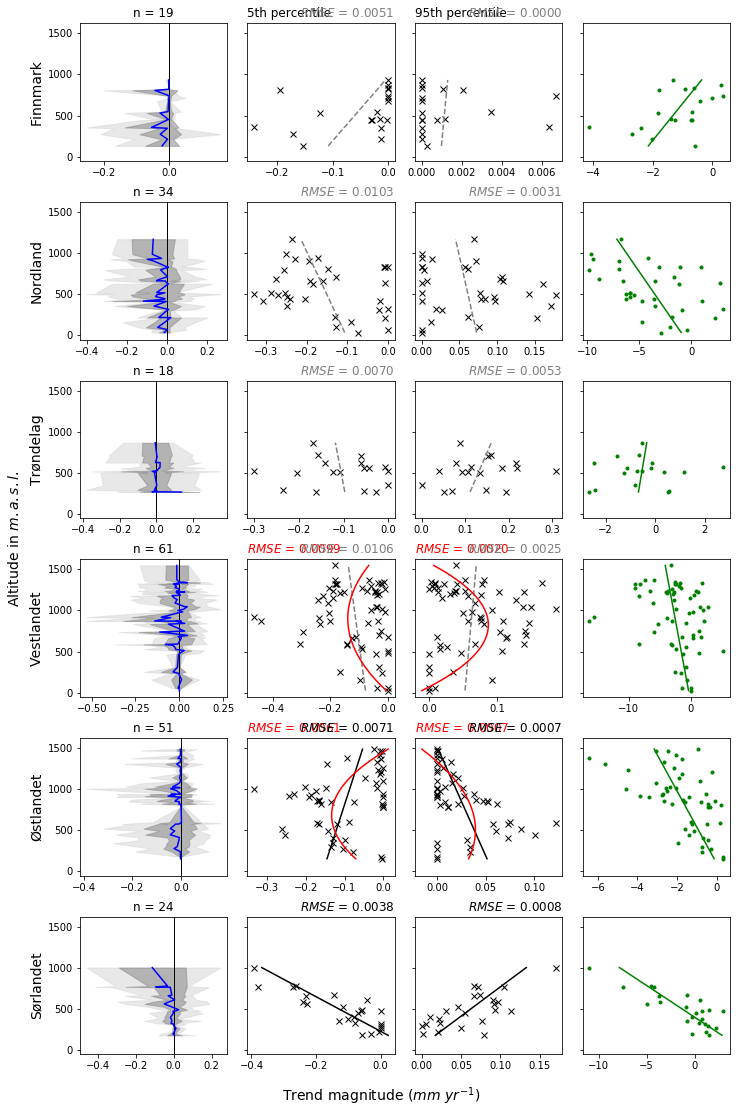

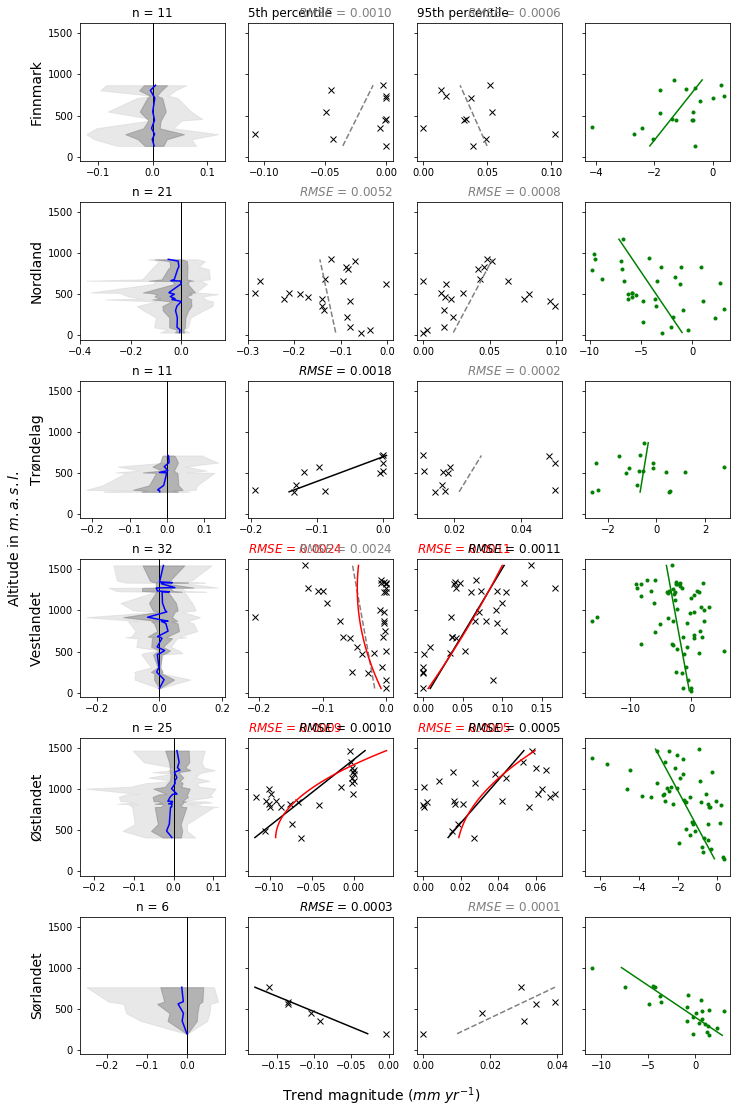

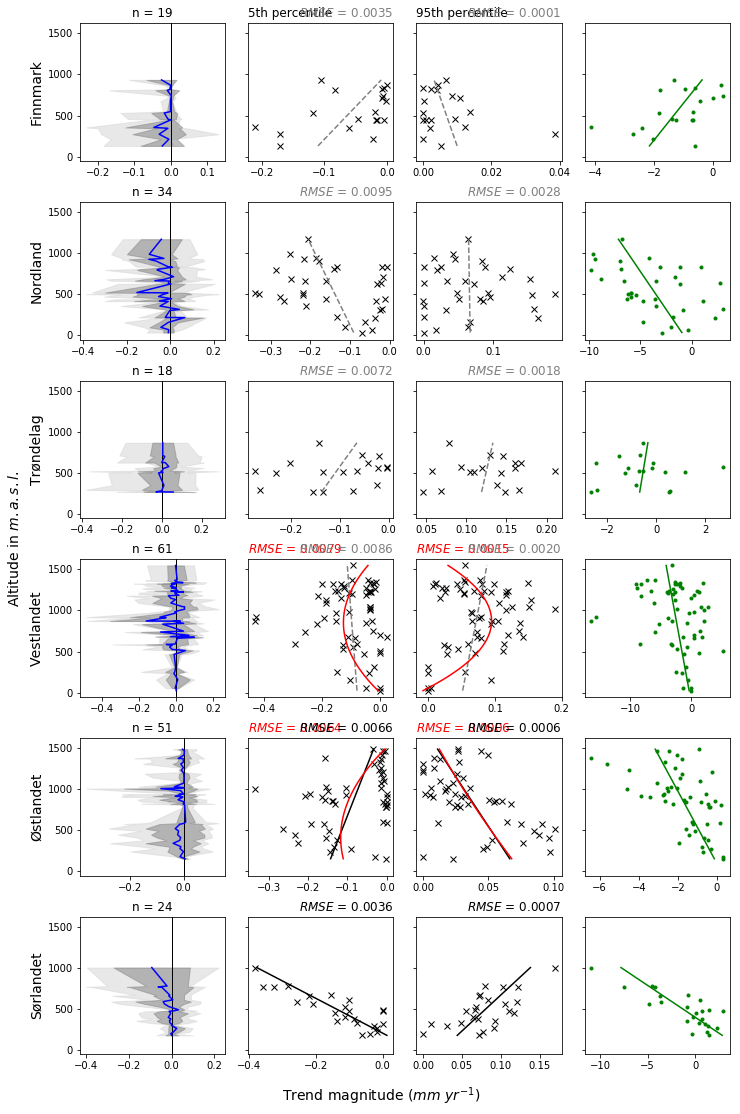

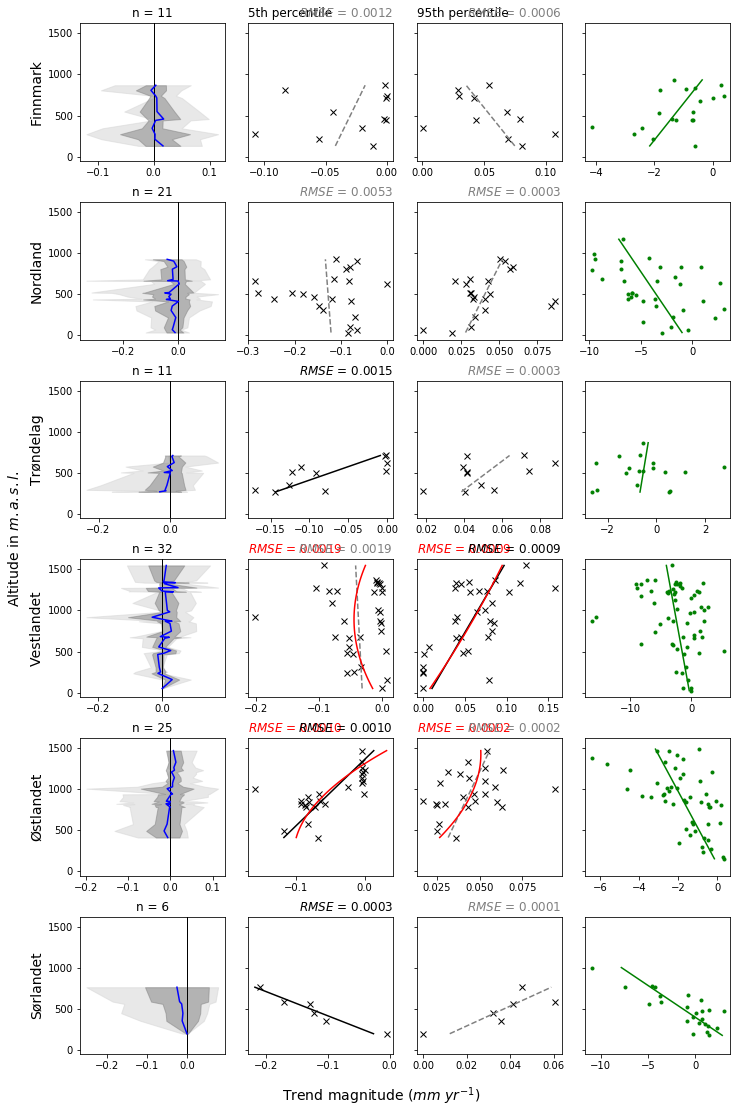

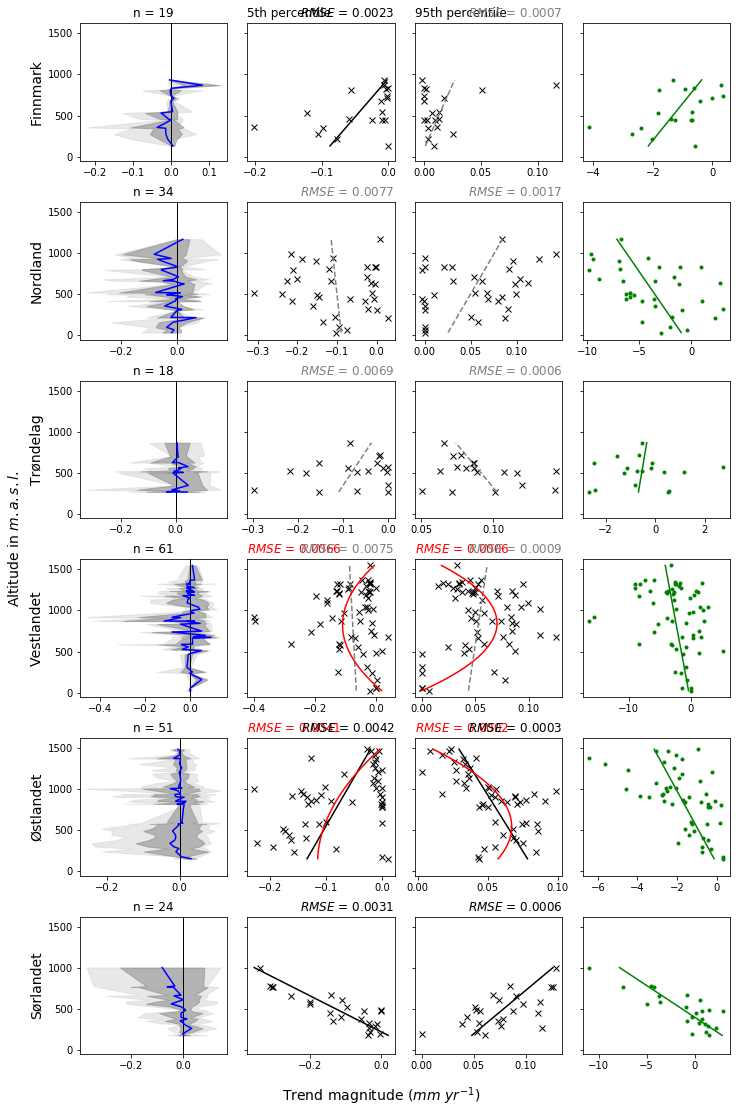

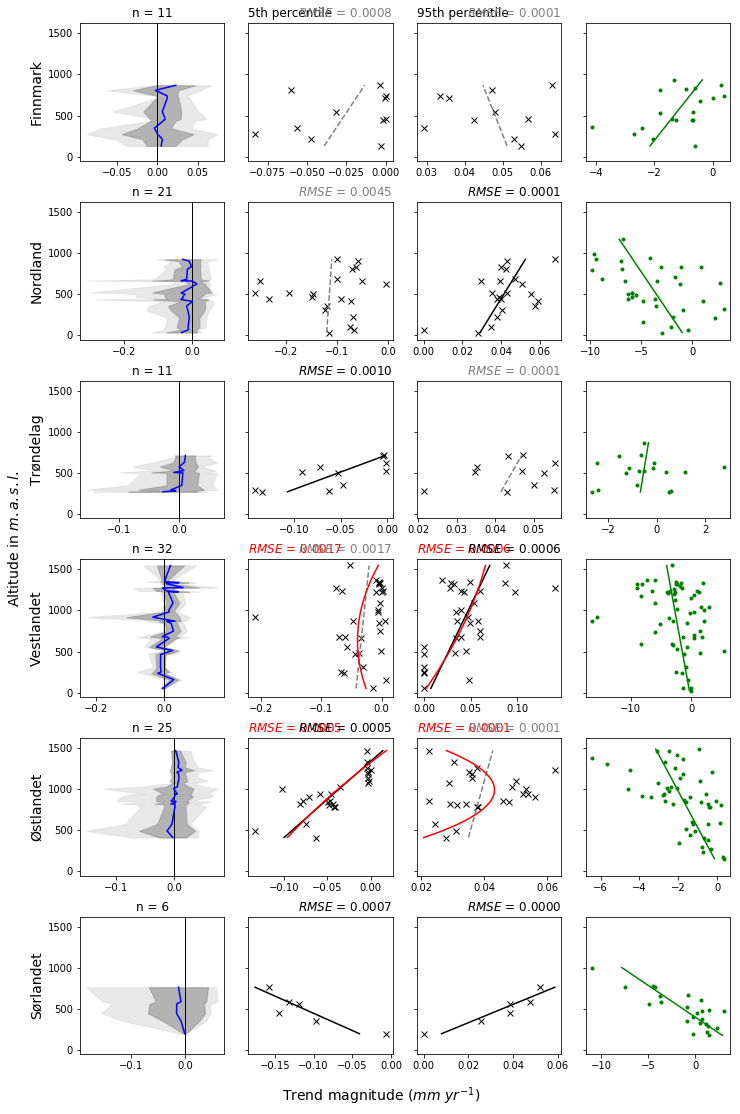

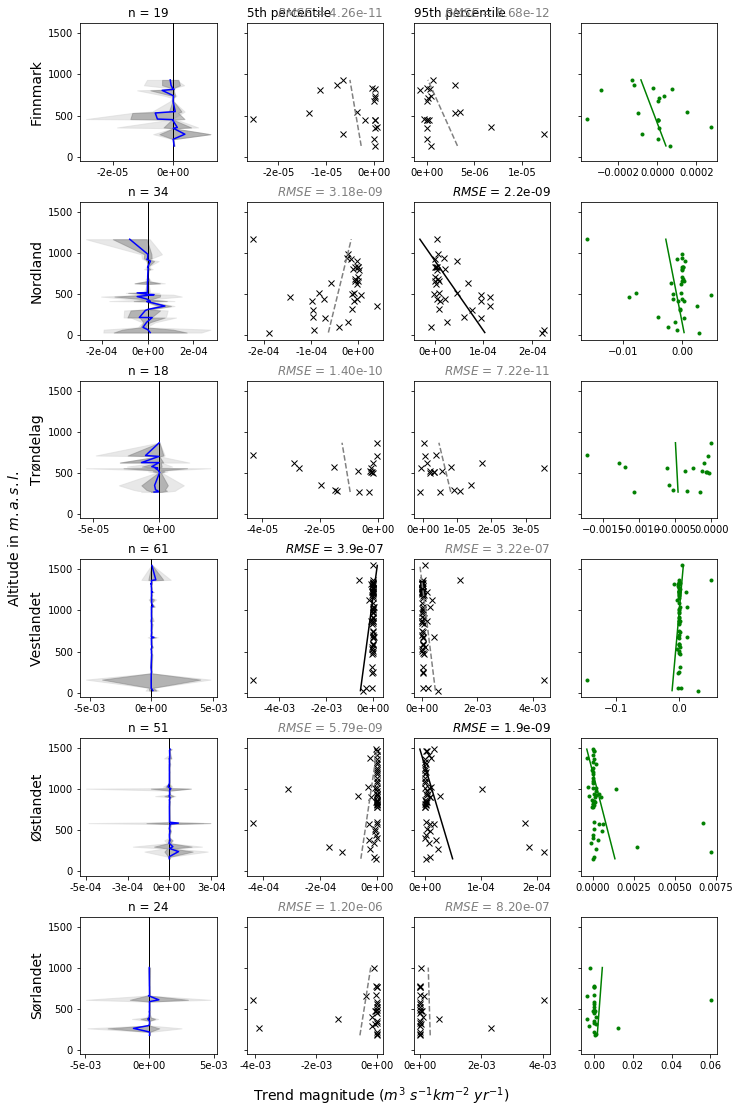

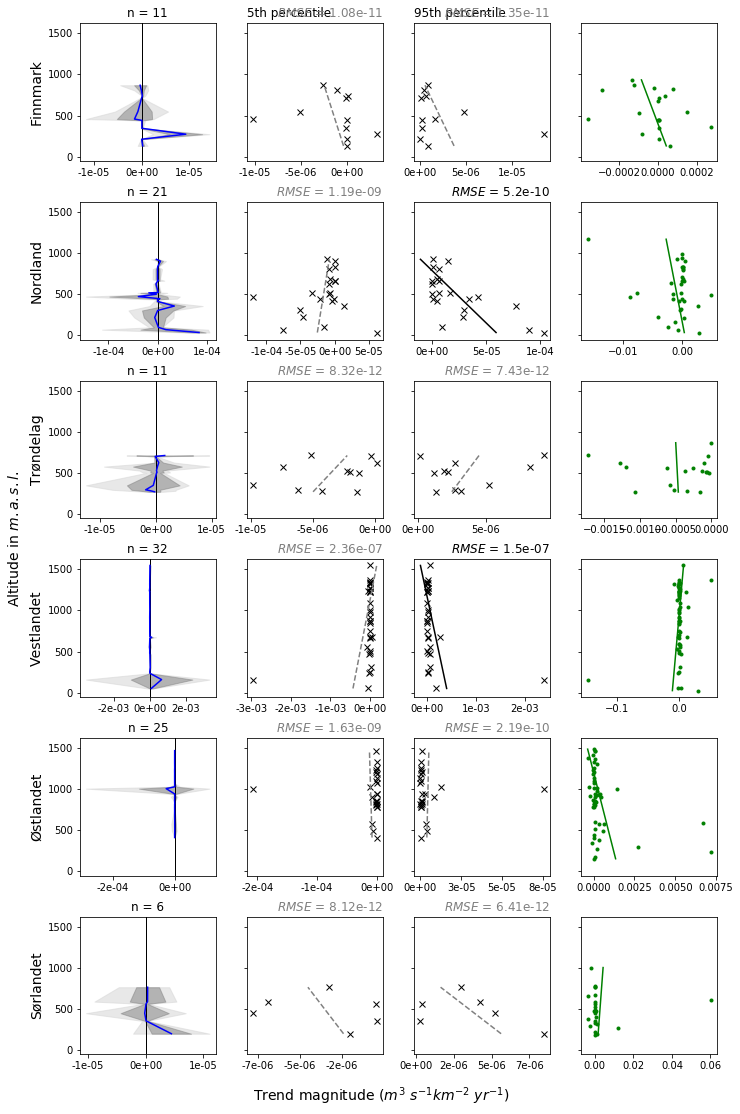

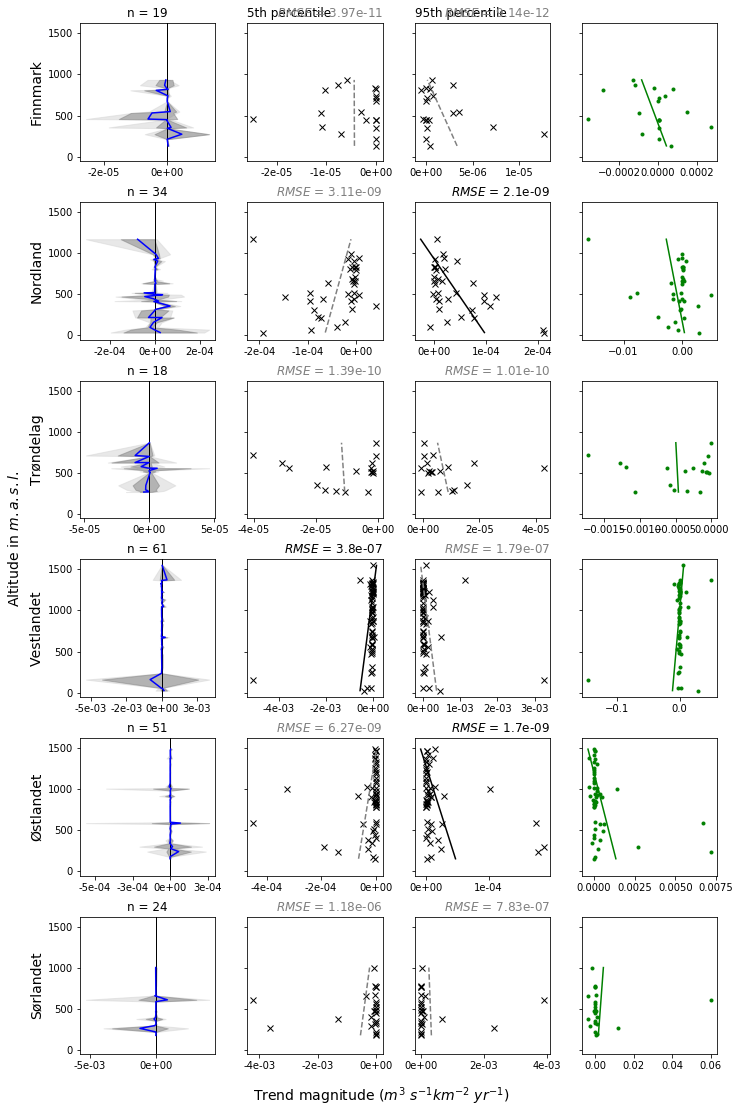

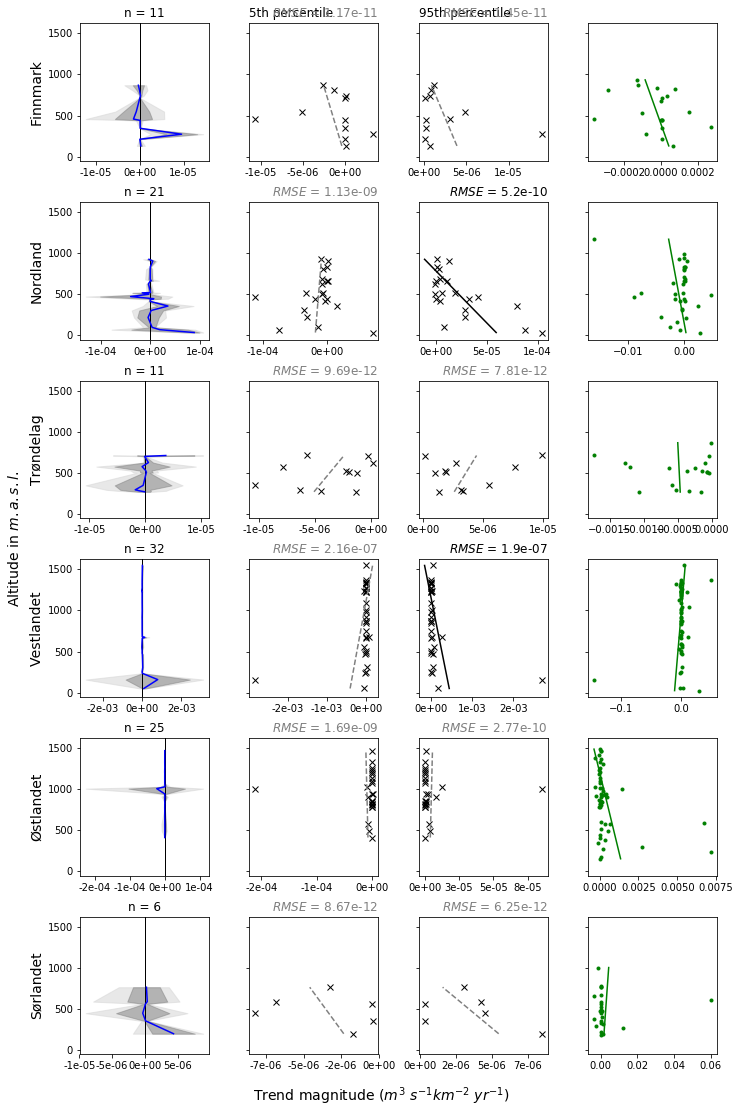

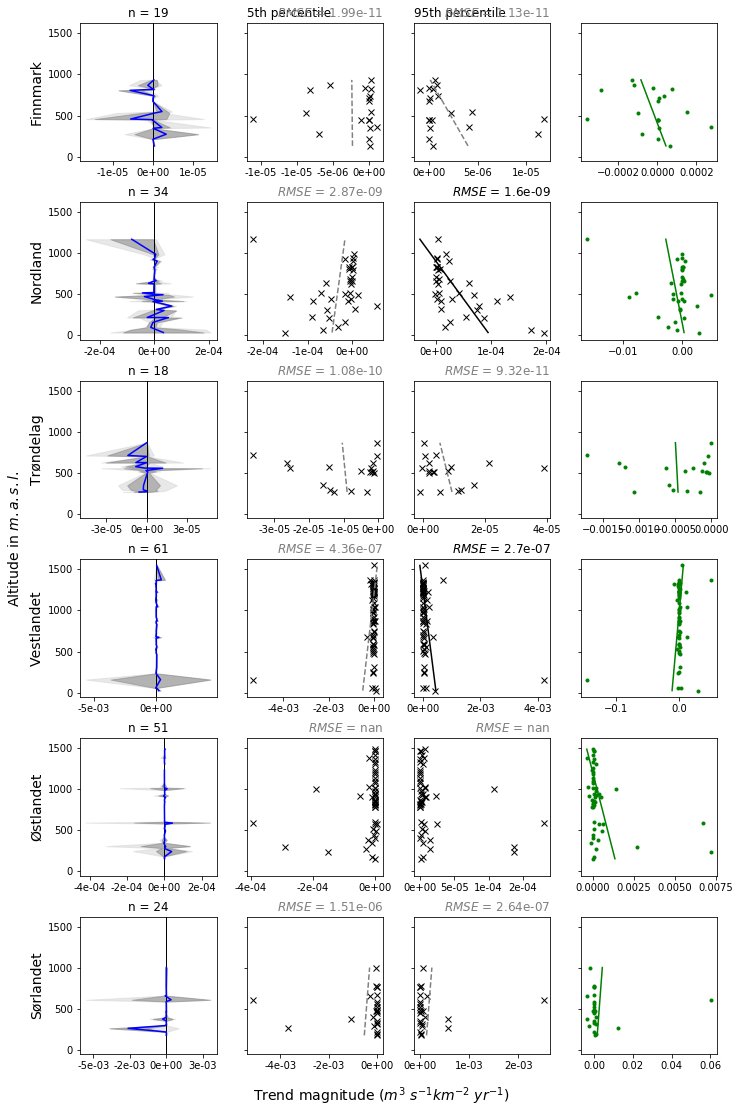

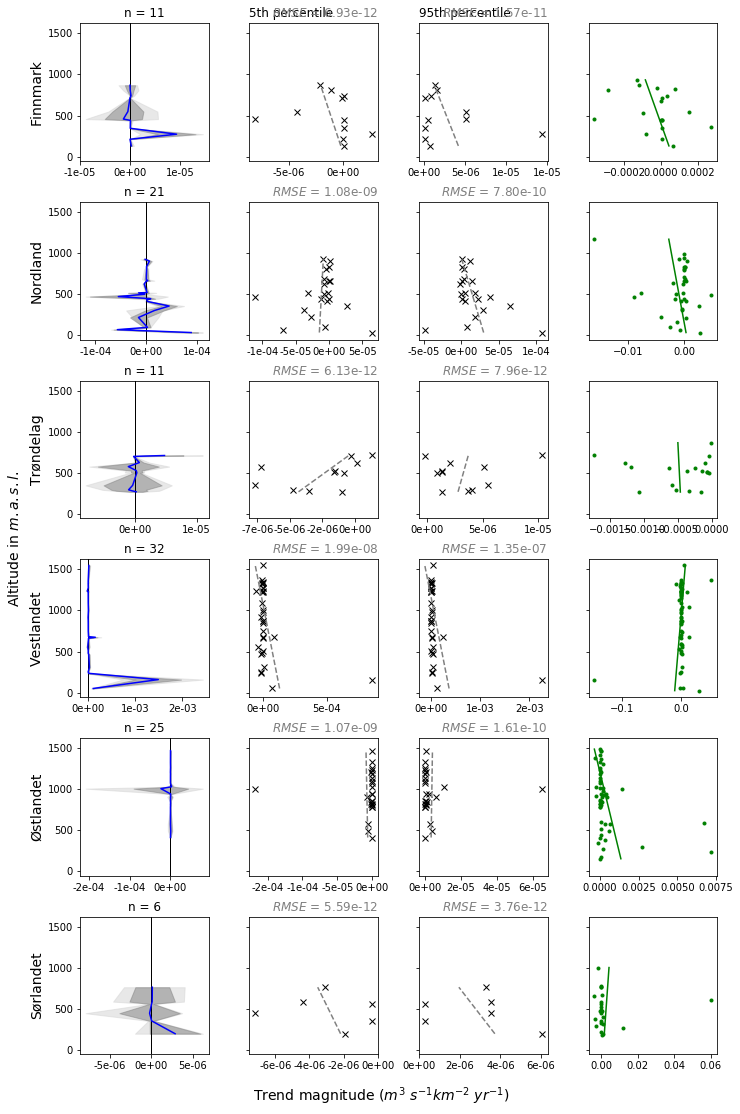

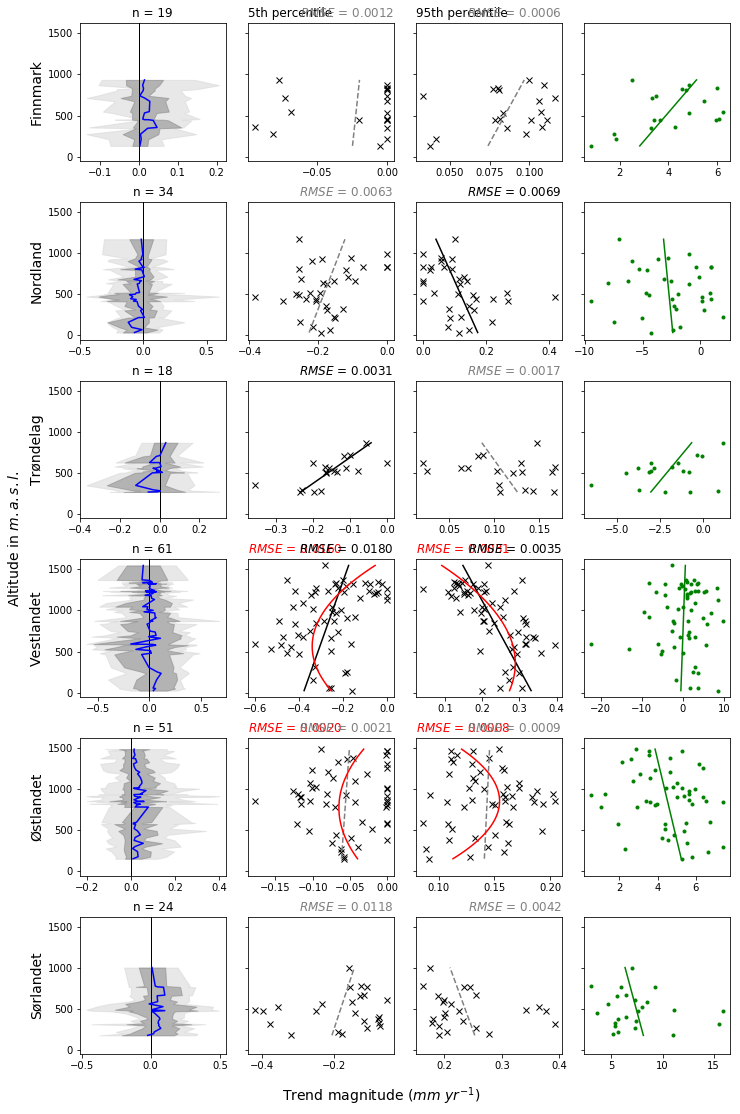

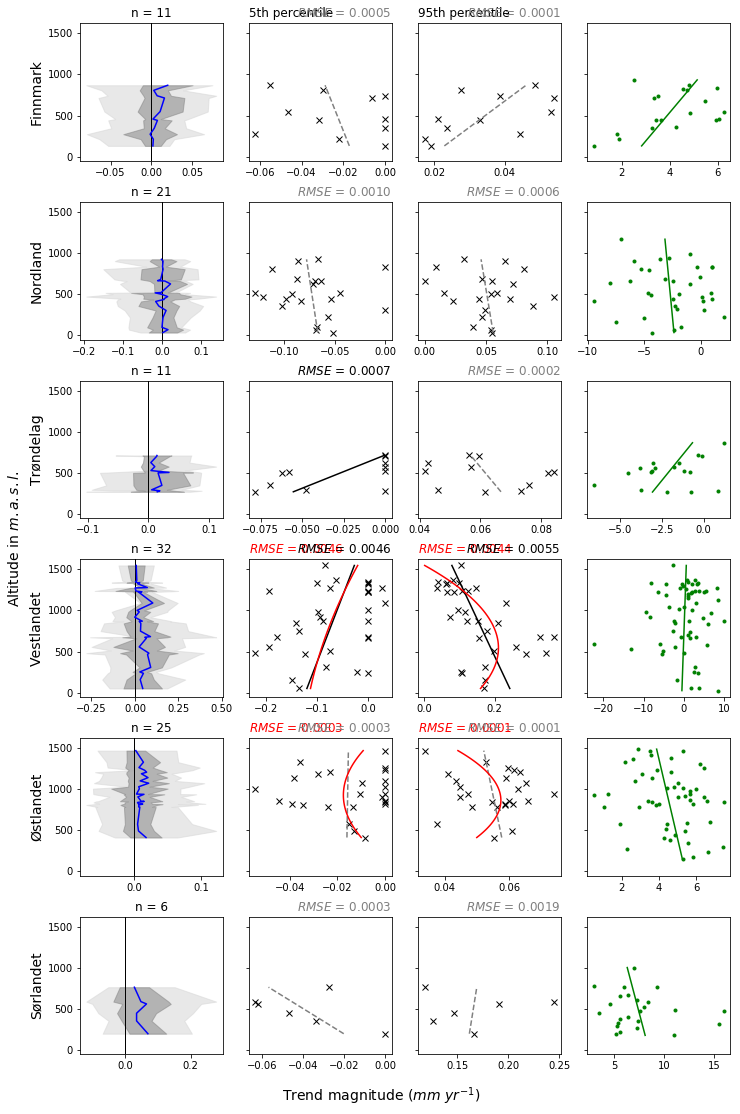

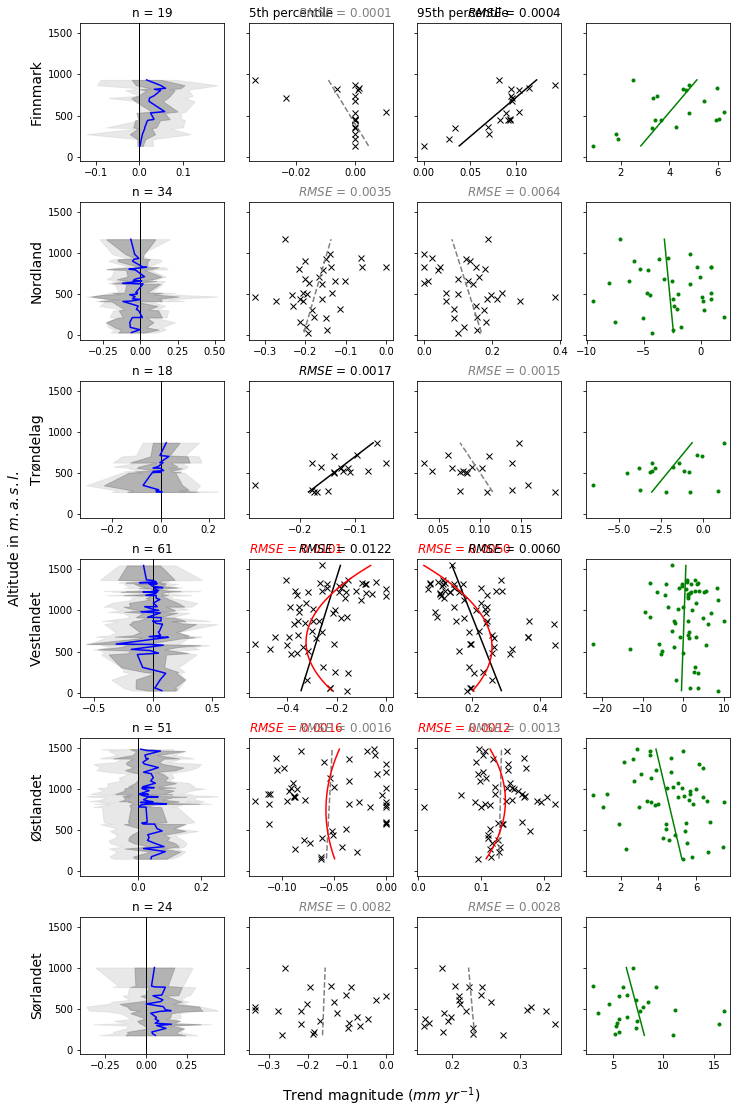

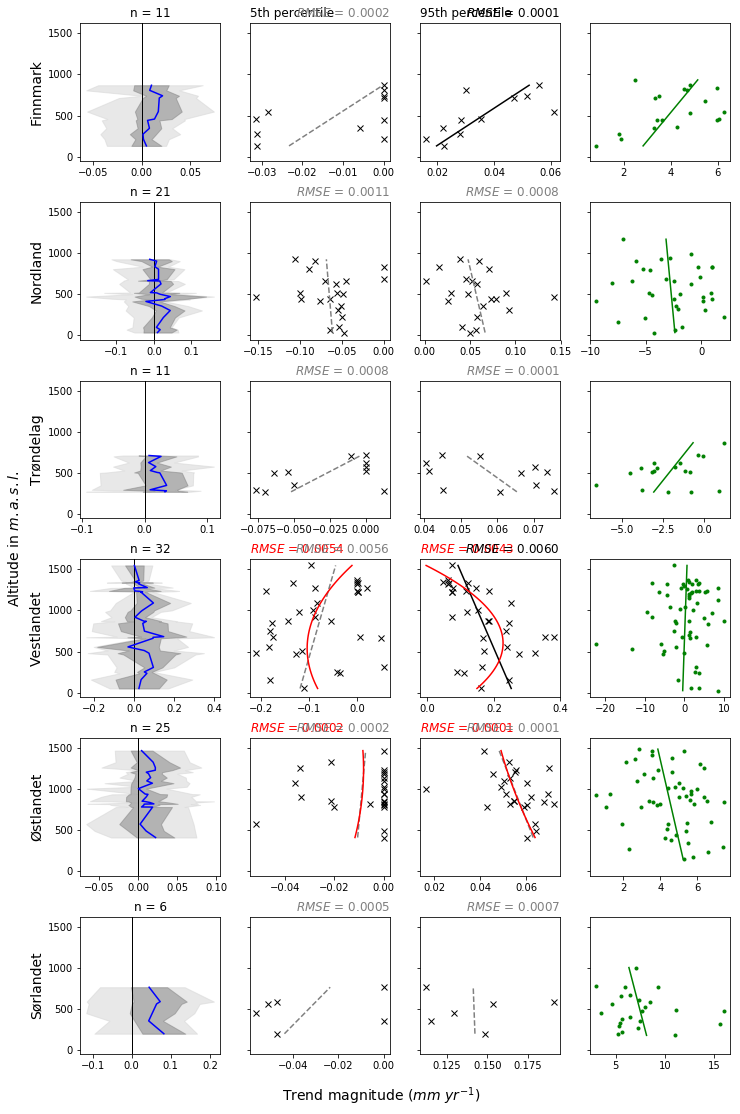

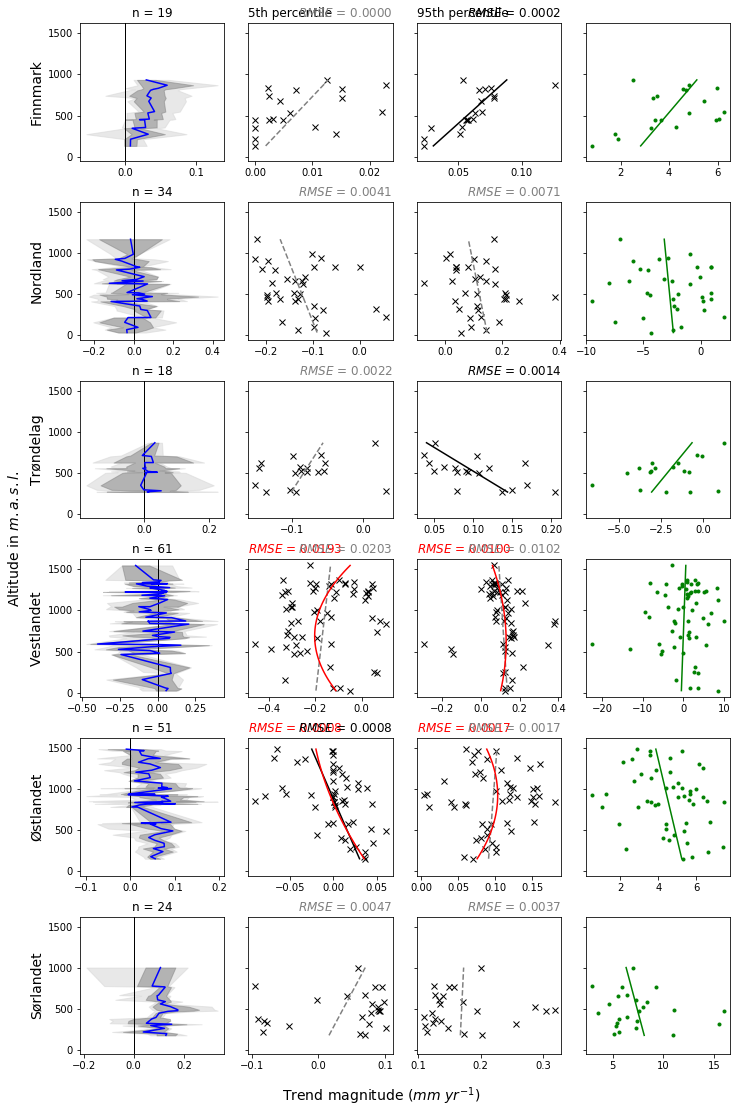

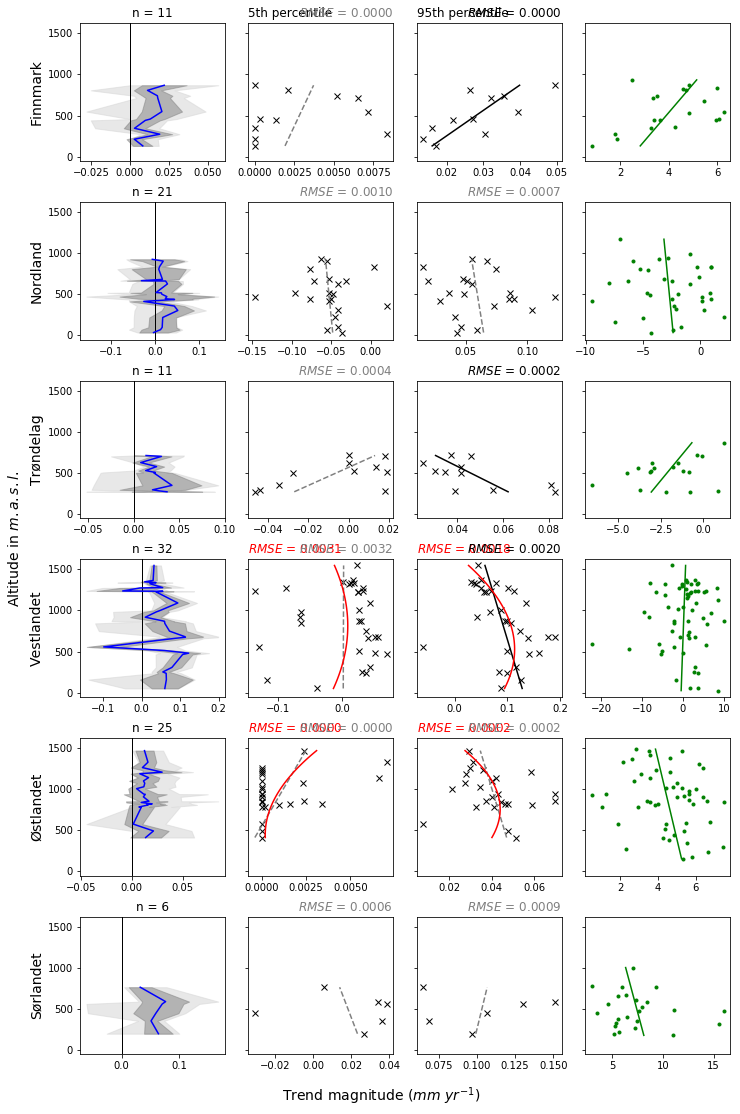

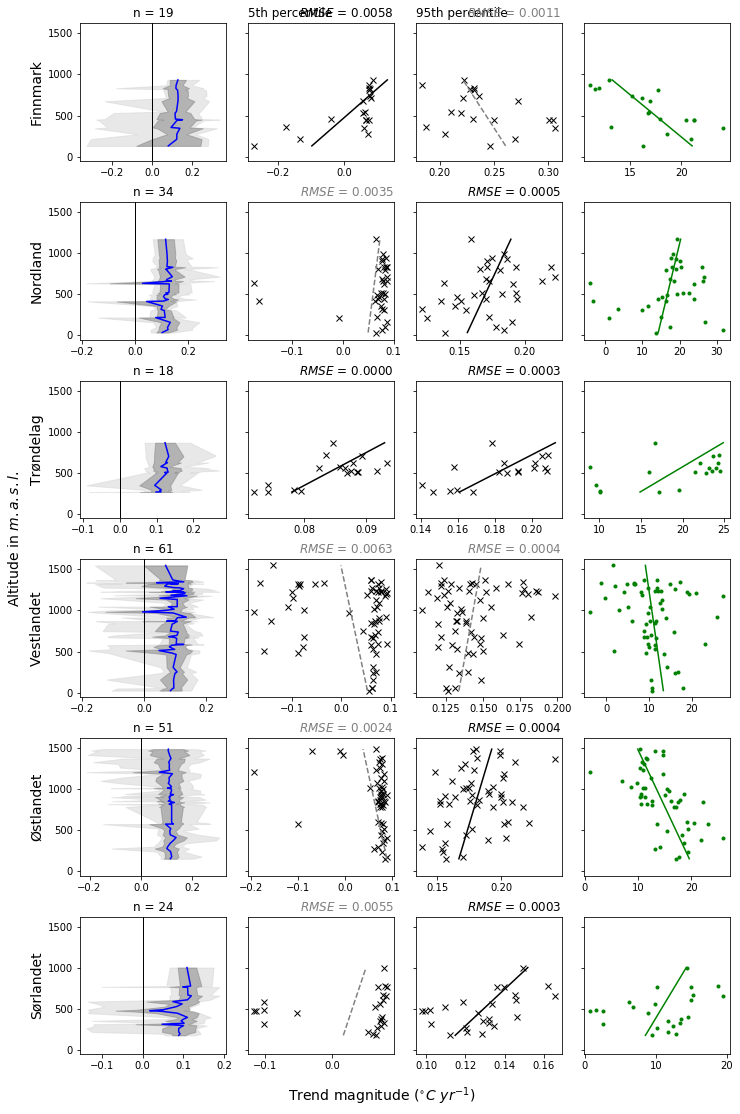

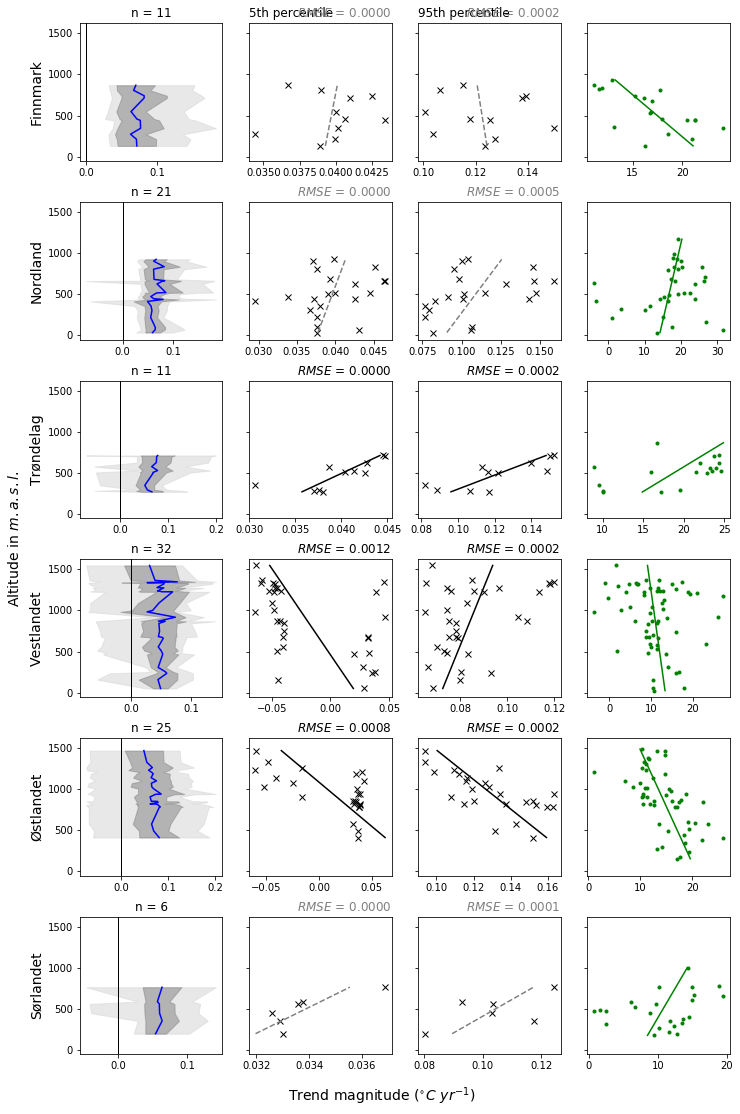

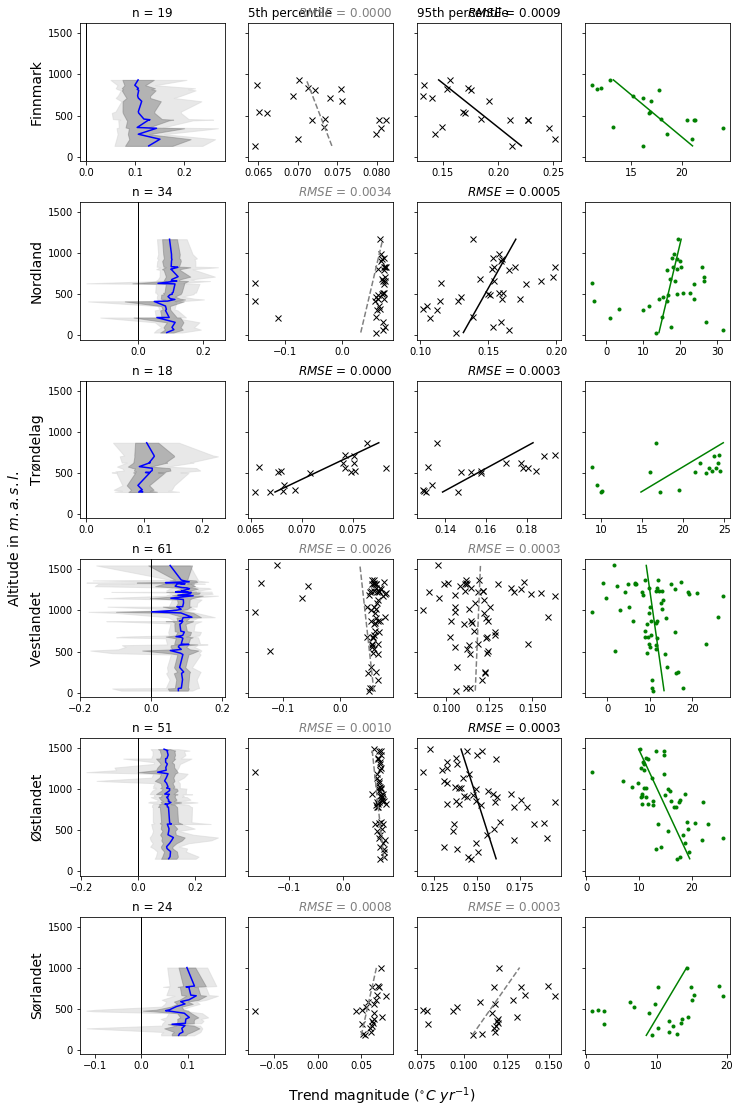

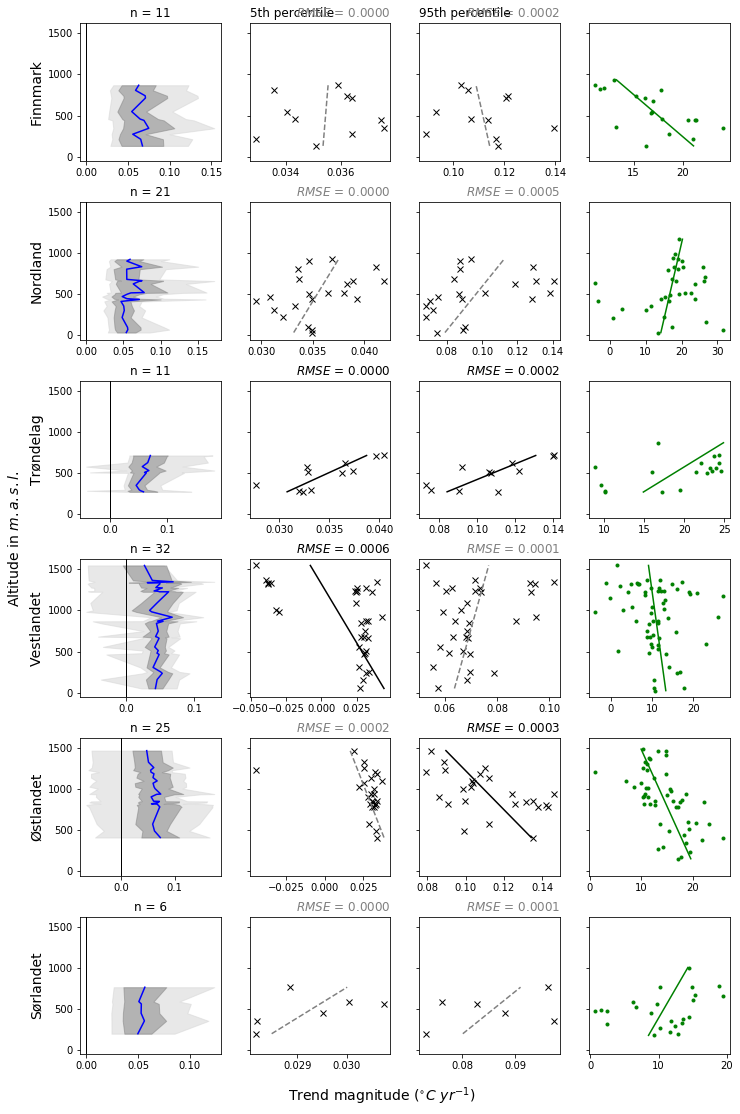

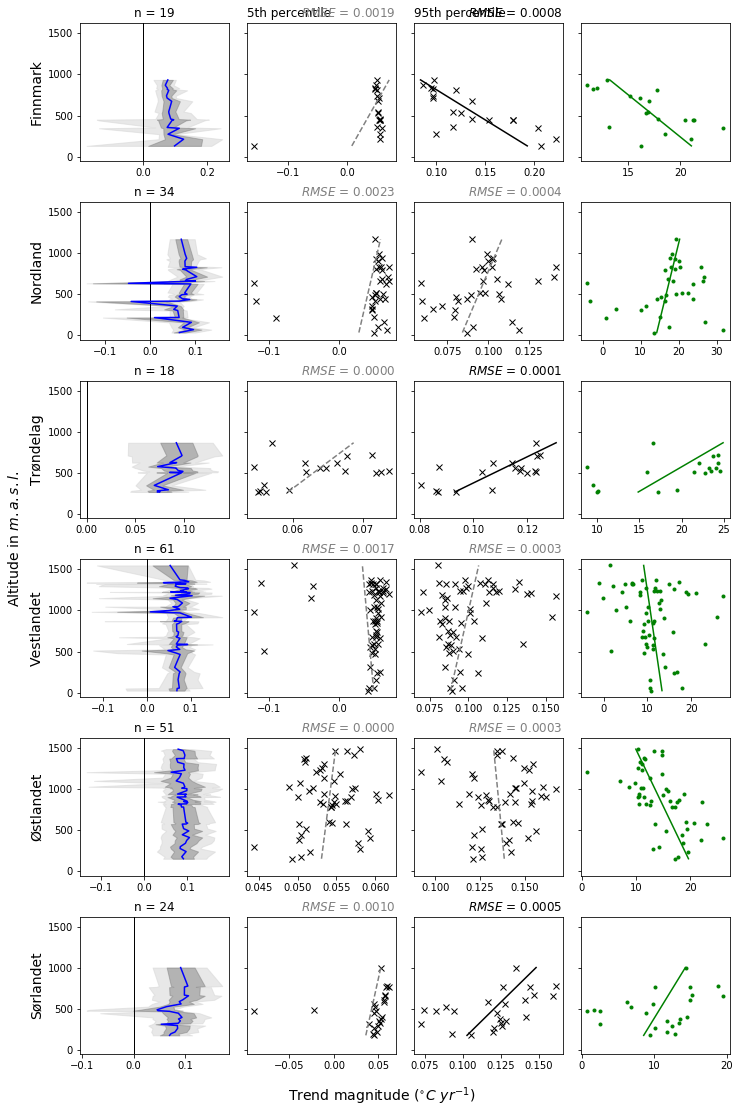

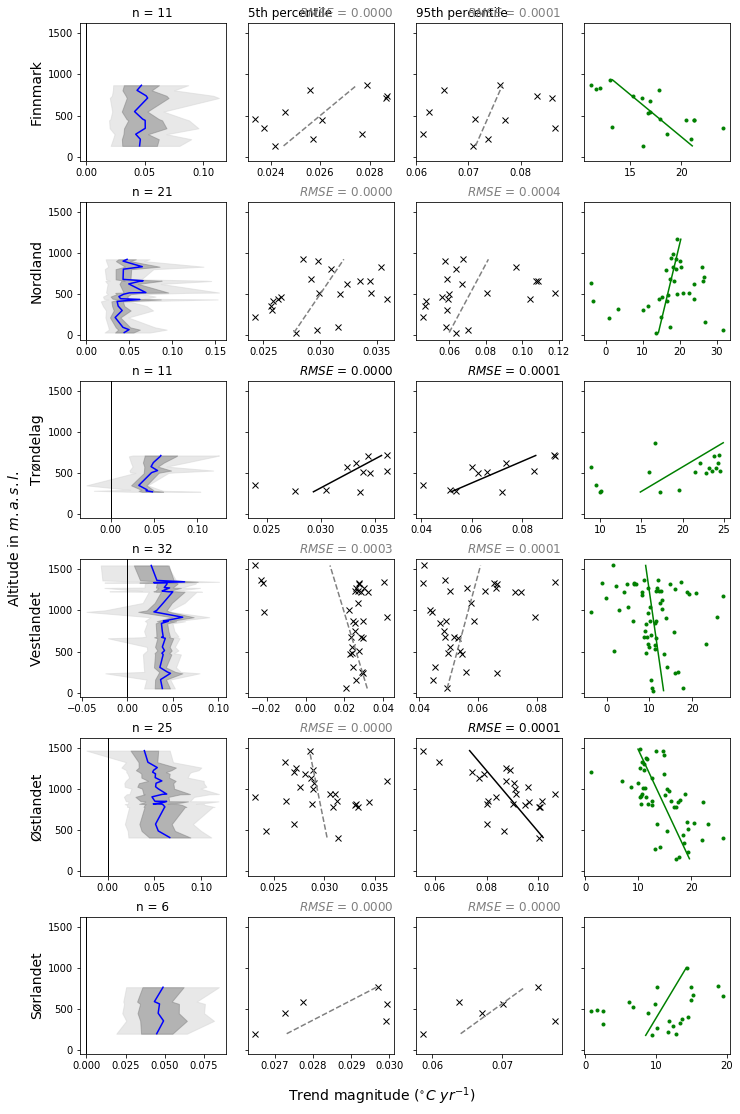

In [105]:
regions = ("finn","nord","trond","vest","ost","sor")

for var in ["snowmelt","streamflow","rainfall","temperature"]:
    for MA in averages:
        for years in [30,50]:

            fig,ax = plt.subplots(nrows=len(regions),ncols=4,sharex=False,sharey=True,figsize=(10,15))
            
            for row in range(len(regions)):
                region = regions[row]
                plotAltMag(region,var,MA,years,subplotting=True,ax=ax[row][0],withMinMax=True)
                plotAltMagPercentile(region,var,5,ax=ax[row][1],years=years,MA=MA)
                plotAltMagPercentile(region,var,95,ax=ax[row][2],years=years,MA=MA)
                dailyTrendSumvsAltitude(region,ax=ax[row][3])
            
            plt.tight_layout(pad=0.8)
            
            fig.text(0.5, -0.02, f"Trend magnitude ({units[var]})", ha='center',fontsize=14)
            fig.text(-0.02, 0.5, "Altitude in $m.a.s.l.$", va='center', rotation='vertical',fontsize=14)
            
            plt.savefig(f"Plots/altitude_{var}Trends_{MA}_{years}year.png",dpi=400,bbox_inches='tight')

In [106]:
regions = ("finn","nord","trond","vest","ost","sor")

for var in ["snowmelt","streamflow","rainfall","temperature"]:
    for MA in averages:
        for years in [30,50]:

            fig,ax = plt.subplots(nrows=len(regions),ncols=3,sharex=False,sharey=True,figsize=(10,15))
            
            for row in range(len(regions)):
                region = regions[row]
                plotAltMag(region,var,MA,years,subplotting=True,ax=ax[row][0],withMinMax=True,head="Mag")
                plotAltMagPercentile(region,var,5,ax=ax[row][1],years=years,MA=MA,head="Mag")
                plotAltMagPercentile(region,var,95,ax=ax[row][2],years=years,MA=MA,head="Mag")
            
            plt.tight_layout(pad=0.8)
            
            fig.text(0.5, -0.02, f"Trend magnitude ({units[var]})", ha='center',fontsize=14)
            fig.text(-0.02, 0.5, "Altitude in $m.a.s.l.$", va='center', rotation='vertical',fontsize=14)
            
            plt.savefig(f"Plots/altitude_onlyMag_{var}_{MA}_{years}year.png",dpi=400,bbox_inches='tight')
            plt.close()

# Trend attribution

In [44]:
def trendCorrelation(head = "Mag",MA = "10day",years = 30, maskSmall=None, correlateWith = "both"):
    qtrend = []
    srtrend = []
    regions = ("finn","nord","trond","vest","ost","sor")
    for region in regions:
        file = findFiles(head=head,variable=f"streamflow_{region}",MA=MA,years=years)[0]
        arr = np.load(file)
        mask = np.unique(np.where(arr!=-99)[0])
        arr = arr[mask,:]
        stream = arr

        file = findFiles(head=head,variable=f"rainfall_{region}",MA=MA,years=years)[0]
        arr = np.load(file)
        mask = np.unique(np.where(arr!=-99)[0])
        arr = arr[mask,:]
        rain = arr

        file = findFiles(head=head,variable=f"snowmelt_{region}",MA=MA,years=years)[0]
        arr = np.load(file)
        mask = np.unique(np.where(arr!=-99)[0])
        arr = arr[mask,:]
        snow = arr
    
        if correlateWith == "both":
            for c in range(stream.shape[0]):
                q = stream[c,:]
                qtrend += list(q)
                d = snow[c,:] + rain[c,:]
                srtrend += list(d)
        elif correlateWith == "snow":
            for c in range(stream.shape[0]):
                q = stream[c,:]
                qtrend += list(q)
                d = snow[c,:]
                srtrend += list(d)
        elif correlateWith == "rain":
            for c in range(stream.shape[0]):
                q = stream[c,:]
                qtrend += list(q)
                d = rain[c,:]
                srtrend += list(d)
            
    plt.figure(figsize=(5,5))
    plt.plot(qtrend,srtrend,"x",color="lightgrey")
    qtrend
    reg1 = stats.linregress(qtrend,srtrend)
    x = np.linspace(np.min(qtrend),np.max(qtrend))
    
    plt.title(f"$r$ = {reg1.rvalue:.2f}",loc="right")
    #plt.title(regionLabels[region])
    plt.xlabel(f'{units["streamflow"]}\nStreamflow trend')
    
    if correlateWith == "both":
        plt.ylabel(f"Snowmelt + rainfall trend\n{units['rainfall']}")
    elif correlateWith == "snow":
        plt.ylabel(f"Snowmelt trend\n{units['rainfall']}")
    elif correlateWith == "rain":
        plt.ylabel(f"Rainfall trend\n{units['rainfall']}")
    
    qtrend = np.array(qtrend)
    srtrend = np.array(srtrend)
    
    if maskSmall:
        mask = ~((qtrend<maskSmall) & (qtrend>-maskSmall))
        qtrend = qtrend[mask]
        srtrend = srtrend[mask]
    
    plt.plot(qtrend,srtrend,"+",color="grey")
    reg = stats.linregress(qtrend,srtrend)
    x = np.linspace(np.min(qtrend),np.max(qtrend))
    plt.plot(x,x*reg1.slope+reg1.intercept,"k",linewidth=3)
    plt.plot(x,x*reg.slope+reg.intercept,"b",linewidth=3)
    plt.title(f"$r$ = {reg.rvalue:.2f}",loc="left",color="b")

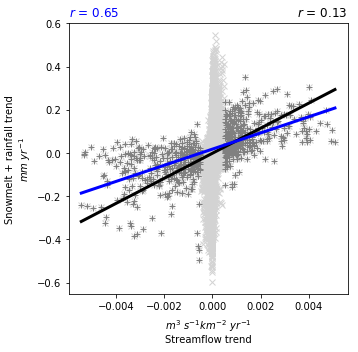

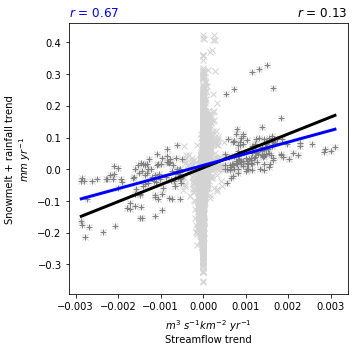

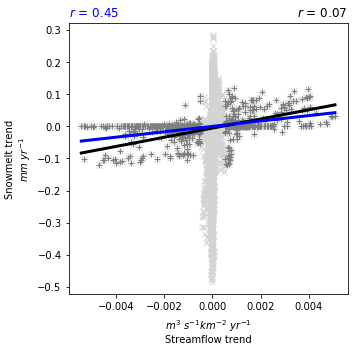

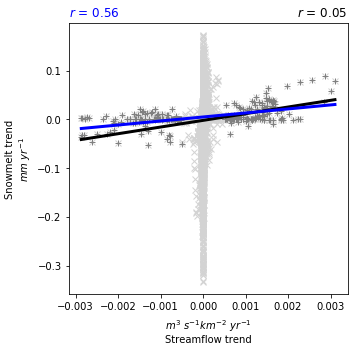

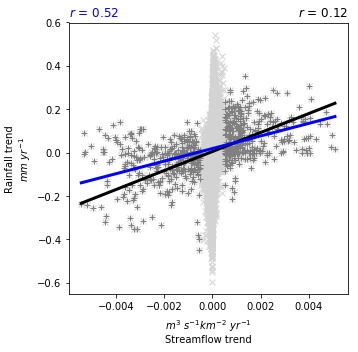

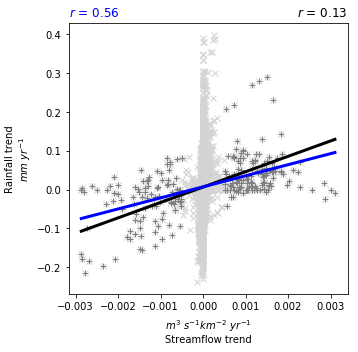

In [46]:
for years in [30,50]:
    trendCorrelation(years=years,maskSmall=0.0005)
    plt.savefig(f"Plots/Trends/trendCorrelation_{years}year.png",dpi=400,bbox_inches='tight')
    
for years in [30,50]:
    trendCorrelation(years=years,maskSmall=0.0005, correlateWith="snow")
    plt.savefig(f"Plots/Trends/trendCorrelation_snowOnly_{years}year.png",dpi=400,bbox_inches='tight')
    
for years in [30,50]:
    trendCorrelation(years=years,maskSmall=0.0005, correlateWith="rain")
    plt.savefig(f"Plots/Trends/trendCorrelation_rainOnly_{years}year.png",dpi=400,bbox_inches='tight')

In [47]:
def sumDays(arr,N=5):
    """
    N day averages of array
    """
    averaged = []
    for i in range(int(arr.shape[1]/N)):
         averaged.append(np.nansum(arr[:,i*N:i*N+N],axis=1))
    return np.array(averaged).T